In [2]:
!pip install rdkit
!pip install torch_geometric

SyntaxError: invalid syntax (104937018.py, line 1)

     ---------------------------------------- 0.0/64.2 kB ? eta -:--:--
     ------ --------------------------------- 10.2/64.2 kB ? eta -:--:--
     ------------------ ------------------- 30.7/64.2 kB 330.3 kB/s eta 0:00:01
     ------------------------------------ - 61.4/64.2 kB 550.5 kB/s eta 0:00:01
     -------------------------------------- 64.2/64.2 kB 431.3 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.1/1.1 MB 3.6 MB/s eta 0:00:01
   ------------- -------------------------- 0.4/1.1 MB 4.6 MB/s eta 0:00:01
   ----------------------- ---------------- 0.6/1.1 MB 5.1 MB/s eta 0:00:01
   -------------------------------- ------- 0.9/1.1 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 5.0 MB/s eta 0:00:00
   -----------

In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, GCNConv, aggr, pool
from torch_geometric.data import DataLoader as PGDataLoader

from sklearn.model_selection import train_test_split

# Uploading dataset
Here I am uploading dataset and checking what does it contain

In [7]:
df = pd.read_csv('dataset_v1.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936962 entries, 0 to 1936961
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   SMILES  object
 1   SPLIT   object
dtypes: object(2)
memory usage: 29.6+ MB
None
                                   SMILES  SPLIT
0  CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1  train
1    CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1  train
2  CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1   test
3     Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO  train
4        Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C  train


This dataset is too big for Google colab, so I decided to cut it (if we are doing this exercise for studing it's easier to work with the small dataset and we don't need it all)

In [8]:
random_sample = df.sample(n=10000)
df = df[df.index.isin(random_sample.index)]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  10000 non-null  object
 1   SPLIT   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [9]:
df

,SMILES,SPLIT
0,Nc1nc2c(ncn2C2CC(CO)C2CO)c(=O)[nH]1,train
1,Cc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1,train
2,O=S(=O)(Cc1ccccc1)NCc1ccccc1,train
3,O=S(=O)(Cc1ccccc1)Nc1nc2ccccc2s1,train
4,CC(=O)Oc1ccccc1C(=O)N1CC(C)OC(C)C1,train
...,...,...
9995,NC(=O)C1CCC(C(=O)OC2CCCCC2)CC1,test_scaffolds
9996,CNS(=O)(=O)c1ccc(C(=O)OC2CCCC(C)C2)cc1,train
9997,CCOc1ccccc1-c1ccc(CO)c(=O)n1C(C)C,train
9998,COC(=O)c1cc(NC(=O)N2CCCC2)ccc1OC,train


## Creating target column

In [10]:
logp = [MolLogP(Chem.MolFromSmiles(x)) for x in df.SMILES]
df['logp'] = logp
df

,SMILES,SPLIT,logp
0,Nc1nc2c(ncn2C2CC(CO)C2CO)c(=O)[nH]1,train,-1.13640
1,Cc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1,train,2.92322
2,O=S(=O)(Cc1ccccc1)NCc1ccccc1,train,2.30620
3,O=S(=O)(Cc1ccccc1)Nc1nc2ccccc2s1,train,3.23820
4,CC(=O)Oc1ccccc1C(=O)N1CC(C)OC(C)C1,train,1.86130
...,...,...,...
9995,NC(=O)C1CCC(C(=O)OC2CCCCC2)CC1,test_scaffolds,2.15400
9996,CNS(=O)(=O)c1ccc(C(=O)OC2CCCC(C)C2)cc1,train,2.33020
9997,CCOc1ccccc1-c1ccc(CO)c(=O)n1C(C)C,train,2.98720
9998,COC(=O)c1cc(NC(=O)N2CCCC2)ccc1OC,train,2.10950


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  10000 non-null  object 
 1   SPLIT   10000 non-null  object 
 2   logp    10000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 234.5+ KB


In [12]:
df = df.drop('SPLIT', axis=1)
df

,SMILES,logp
0,Nc1nc2c(ncn2C2CC(CO)C2CO)c(=O)[nH]1,-1.13640
1,Cc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1,2.92322
2,O=S(=O)(Cc1ccccc1)NCc1ccccc1,2.30620
3,O=S(=O)(Cc1ccccc1)Nc1nc2ccccc2s1,3.23820
4,CC(=O)Oc1ccccc1C(=O)N1CC(C)OC(C)C1,1.86130
...,...,...
9995,NC(=O)C1CCC(C(=O)OC2CCCCC2)CC1,2.15400
9996,CNS(=O)(=O)c1ccc(C(=O)OC2CCCC(C)C2)cc1,2.33020
9997,CCOc1ccccc1-c1ccc(CO)c(=O)n1C(C)C,2.98720
9998,COC(=O)c1cc(NC(=O)N2CCCC2)ccc1OC,2.10950


## Fingerprints from RDKit

In [13]:
def get_fingerprint(smiles):
  '''Function which returns Morgan fingerprints from RDKit'''
  fp_array = np.zeros((0,), dtype=np.int8)
  mol = Chem.MolFromSmiles(smiles)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
  ConvertToNumpyArray(fp, fp_array)
  return fp_array

In [14]:
# Creating fingerprints with function
df['fingerprints'] = df.SMILES.tolist()
df['fingerprints'] = df.fingerprints.apply(get_fingerprint)

# Now we have column with fingerprints, but for prediction we want to have single digit in each column

# Changing fingerprint format
new_fingerprints = np.vstack(df['fingerprints'].values)
new_fingerprint_columns = [f'fingerprint_{i}' for i in range(new_fingerprints.shape[1])]
new_fingerprint_df = pd.DataFrame(new_fingerprints, columns=new_fingerprint_columns)

df = pd.concat([df, new_fingerprint_df], axis=1)
df = df.drop('fingerprints', axis=1)

In [15]:
df

,SMILES,logp,fingerprint_0,fingerprint_1,fingerprint_2,fingerprint_3,fingerprint_4,fingerprint_5,fingerprint_6,fingerprint_7,...,fingerprint_2038,fingerprint_2039,fingerprint_2040,fingerprint_2041,fingerprint_2042,fingerprint_2043,fingerprint_2044,fingerprint_2045,fingerprint_2046,fingerprint_2047
0,Nc1nc2c(ncn2C2CC(CO)C2CO)c(=O)[nH]1,-1.13640,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Cc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1,2.92322,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=S(=O)(Cc1ccccc1)NCc1ccccc1,2.30620,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,O=S(=O)(Cc1ccccc1)Nc1nc2ccccc2s1,3.23820,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CC(=O)Oc1ccccc1C(=O)N1CC(C)OC(C)C1,1.86130,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NC(=O)C1CCC(C(=O)OC2CCCCC2)CC1,2.15400,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,CNS(=O)(=O)c1ccc(C(=O)OC2CCCC(C)C2)cc1,2.33020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,CCOc1ccccc1-c1ccc(CO)c(=O)n1C(C)C,2.98720,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,COC(=O)c1cc(NC(=O)N2CCCC2)ccc1OC,2.10950,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Linear regression

This part of code is created with using materials from the lectures

In [16]:
def get_loss(X, y, weights):
    y_pred = X.dot(weights)
    return np.mean((y - y_pred)**2)

def gradient_descent(X_train, y_train, X_test, y_test, weights, lr, iters):

    train_losses = []
    test_losses = []

    for i in tqdm(range(iters)):

        # обучение
        predictions_train = np.dot(X_train, weights)
        error_train = predictions_train - y_train
        gradient = np.dot(X_train.T, error_train) / len(y_train)
        weights -= lr * gradient

        # вычисляем ошибку
        train_loss = get_loss(X_train, y_train, weights)
        test_loss = get_loss(X_test, y_test, weights)

        # сохраняем в историю
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    # строим график
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.legend()
    plt.xlabel('Iters')
    plt.ylabel('MSE')
    plt.show()

    return weights

## Preparing data for function implementation

In [17]:
data = df.values
m = len(data[:,-1])
X = df.iloc[:, 2:].values
y = df['logp'].values
y = y[:, np.newaxis]

# Adding new columns from ones for bias
X = np.hstack([np.ones((X.shape[0], 1)), X])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

100%|██████████| 1000/1000 [00:43<00:00, 23.15it/s]


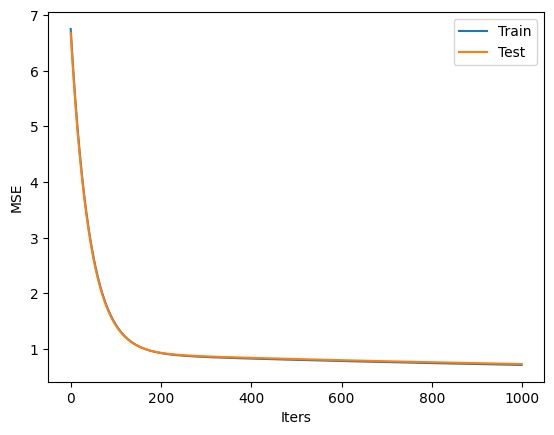

In [19]:
weights = np.zeros((X.shape[1], 1))
weights = gradient_descent(X_train, y_train, X_test, y_test, weights, 0.001, 1000)

In [20]:
y_train_pred = np.dot(X_train, weights)
y_test_pred = np.dot(X_test, weights)

# ВCalculating MSE for train and test
train_mse = get_loss(X_train, y_train.reshape(-1, 1), weights)
test_mse = get_loss(X_test, y_test.reshape(-1, 1), weights)

print("MSE для обучающей выборки:", train_mse)
print("MSE для тестовой выборки:", test_mse)

MSE для обучающей выборки: 0.7121681580277018
MSE для тестовой выборки: 0.7285933311139077


## Graph representation

In [21]:
df.head()

,SMILES,logp,fingerprint_0,fingerprint_1,fingerprint_2,fingerprint_3,fingerprint_4,fingerprint_5,fingerprint_6,fingerprint_7,...,fingerprint_2038,fingerprint_2039,fingerprint_2040,fingerprint_2041,fingerprint_2042,fingerprint_2043,fingerprint_2044,fingerprint_2045,fingerprint_2046,fingerprint_2047
0,Nc1nc2c(ncn2C2CC(CO)C2CO)c(=O)[nH]1,-1.13640,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Cc1nc(N)nc(N)c1-c1ccc(Cl)c(Cl)c1,2.92322,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=S(=O)(Cc1ccccc1)NCc1ccccc1,2.30620,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,O=S(=O)(Cc1ccccc1)Nc1nc2ccccc2s1,3.23820,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CC(=O)Oc1ccccc1C(=O)N1CC(C)OC(C)C1,1.86130,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now our dataset contains fingerprints. For using GNN we do not need them. So, we can drop fingerprints now

In [22]:
df = df.iloc[:, :2]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  10000 non-null  object 
 1   logp    10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


### Functions for creating graph data which will be used for model learning and further predictions

In [23]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding


def get_atom_features(atom,
                      use_chirality = True,
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms

    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

    # compute atom features

    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

    is_in_a_ring_enc = [int(atom.IsInRing())]

    is_aromatic_enc = [int(atom.GetIsAromatic())]

    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc

    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)


def get_bond_features(bond,
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

    bond_is_conj_enc = [int(bond.GetIsConjugated())]

    bond_is_in_ring_enc = [int(bond.IsInRing())]

    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)


def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:

    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

    Outputs:

    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

    """

    data_list = []

    for (smiles, y_val) in tqdm(zip(x_smiles, y), total=len(x_smiles)):

        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)

        X = torch.tensor(X, dtype = torch.float)

        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)

        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))

        for (k, (i,j)) in enumerate(zip(rows, cols)):

            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

        EF = torch.tensor(EF, dtype = torch.float)

        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)

        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [24]:
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(df['SMILES'], df['logp'])

100%|██████████| 10000/10000 [00:35<00:00, 283.24it/s]


In [30]:
data_list

[Data(x=[19, 79], edge_index=[2, 42], edge_attr=[42, 10], y=[1]),
 Data(x=[17, 79], edge_index=[2, 36], edge_attr=[36, 10], y=[1]),
 Data(x=[18, 79], edge_index=[2, 38], edge_attr=[38, 10], y=[1]),
 Data(x=[20, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]),
 Data(x=[20, 79], edge_index=[2, 42], edge_attr=[42, 10], y=[1]),
 Data(x=[20, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]),
 Data(x=[16, 79], edge_index=[2, 32], edge_attr=[32, 10], y=[1]),
 Data(x=[21, 79], edge_index=[2, 46], edge_attr=[46, 10], y=[1]),
 Data(x=[21, 79], edge_index=[2, 48], edge_attr=[48, 10], y=[1]),
 Data(x=[24, 79], edge_index=[2, 52], edge_attr=[52, 10], y=[1]),
 Data(x=[24, 79], edge_index=[2, 52], edge_attr=[52, 10], y=[1]),
 Data(x=[22, 79], edge_index=[2, 46], edge_attr=[46, 10], y=[1]),
 Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]),
 Data(x=[19, 79], edge_index=[2, 42], edge_attr=[42, 10], y=[1]),
 Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]),
 Data(x=[2

In [25]:
train_idx, test_idx = train_test_split(range(len(data_list)), test_size=0.2, random_state=2024)

# Создаем списки для train и test графов
train = [data_list[i] for i in train_idx]
test = [data_list[i] for i in test_idx]

In [31]:
print(f'train: {train}')

train: [Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]), Data(x=[25, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]), Data(x=[19, 79], edge_index=[2, 40], edge_attr=[40, 10], y=[1]), Data(x=[22, 79], edge_index=[2, 46], edge_attr=[46, 10], y=[1]), Data(x=[25, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[22, 79], edge_index=[2, 48], edge_attr=[48, 10], y=[1]), Data(x=[18, 79], edge_index=[2, 38], edge_attr=[38, 10], y=[1]), Data(x=[22, 79], edge_index=[2, 46], edge_attr=[46, 10], y=[1]), Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]), Data(x=[24, 79], edge_index=[2, 52], edge_attr=[52, 10], y=[1]), Data(x=[26, 79], edge_index=[2, 58], edge_attr=[58, 10], y=[1]), Data(x=[21, 79], edge_index=[2, 48], edge_attr=[48, 10], y=[1]), Data(x=[22, 79], edge_index=[2, 46], edge_attr=[46, 10], y=[1]), Data(x=[26, 79], edge_index=[2, 58], edge_attr=[58, 10], y=[1]), Data(x=[18, 79], 

### Neural Net

In [26]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(79, 32)
        self.conv2 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 1)
        self.mean_pooling = pool.global_mean_pool

    def forward(self, data):
        x, edge_index= data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.mean_pooling(x, data.batch)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        return x

In [27]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gnn_model = GCN().to(device)

train_dataloader = PGDataLoader(dataset=train, batch_size=100)
test_dataloader = PGDataLoader(dataset=test, batch_size=100)

optimiser = torch.optim.Adam(gnn_model.parameters(), lr=1e-3)
loss_function = MSELoss()

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [28]:
for epoch in range(1000):

    # set model to training mode
    gnn_model.train()
    losses = []
    # loop over minibatches for training
    for (k, batch) in tqdm(enumerate(train_dataloader), total = len(train) // 2**7):

        # compute current value of loss function via forward pass
        output = gnn_model(batch.to(device))
        loss_function_value = loss_function(output[:,0], batch.y)
        losses.append(loss_function_value.detach().cpu())
        # set past gradient to zero
        optimiser.zero_grad()

        # compute current gradient via backward pass
        loss_function_value.backward()

        # update model weights using gradient and optimisation method
        optimiser.step()

    losses_test = []

    with torch.no_grad():

        for (k, batch) in tqdm(enumerate(test_dataloader), total = len(test) // 2**7):

            # compute current value of loss function via forward pass
            output = gnn_model(batch.to(device))
            loss_function_value = loss_function(output[:,0], batch.y)
            losses_test.append(loss_function_value.detach().cpu())


    test_line = 'train loss: %1.4f\ntest loss: %1.4f'
    print(test_line % (np.mean(losses), np.mean(losses_test)))

80it [00:02, 30.28it/s]
20it [00:00, 91.42it/s]


train loss: 3.7284
test loss: 0.8129


80it [00:01, 44.23it/s]
20it [00:00, 52.10it/s]


train loss: 0.8057
test loss: 0.7867


80it [00:01, 45.14it/s]
20it [00:00, 85.97it/s]


train loss: 0.7684
test loss: 0.7590


80it [00:01, 61.49it/s]
20it [00:00, 86.38it/s]


train loss: 0.7332
test loss: 0.7189


80it [00:01, 63.27it/s]
20it [00:00, 86.79it/s]


train loss: 0.6966
test loss: 0.6723


80it [00:01, 60.28it/s]
20it [00:00, 84.25it/s]


train loss: 0.6400
test loss: 0.6075


80it [00:01, 58.58it/s]
20it [00:00, 72.50it/s]


train loss: 0.5725
test loss: 0.5365


80it [00:01, 62.77it/s]
20it [00:00, 80.01it/s]


train loss: 0.5027
test loss: 0.4795


80it [00:01, 61.47it/s]
20it [00:00, 62.36it/s]


train loss: 0.4494
test loss: 0.4217


80it [00:01, 41.87it/s]
20it [00:00, 51.38it/s]


train loss: 0.3954
test loss: 0.3665


80it [00:02, 36.07it/s]
20it [00:00, 57.20it/s]


train loss: 0.3407
test loss: 0.3113


80it [00:01, 41.53it/s]
20it [00:00, 85.61it/s]


train loss: 0.3054
test loss: 0.2862


80it [00:01, 62.28it/s]
20it [00:00, 83.82it/s]


train loss: 0.2808
test loss: 0.2568


80it [00:01, 61.88it/s]
20it [00:00, 86.23it/s]


train loss: 0.2519
test loss: 0.2459


80it [00:01, 57.95it/s]
20it [00:00, 81.87it/s]


train loss: 0.2402
test loss: 0.2248


80it [00:01, 58.43it/s]
20it [00:00, 81.43it/s]


train loss: 0.2230
test loss: 0.2176


80it [00:01, 43.92it/s]
20it [00:00, 56.65it/s]


train loss: 0.2169
test loss: 0.2084


80it [00:01, 46.39it/s]
20it [00:00, 82.97it/s]


train loss: 0.2119
test loss: 0.2154


80it [00:01, 62.65it/s]
20it [00:00, 89.66it/s]


train loss: 0.2068
test loss: 0.2028


80it [00:01, 62.92it/s]
20it [00:00, 84.73it/s]


train loss: 0.1980
test loss: 0.1976


80it [00:01, 61.48it/s]
20it [00:00, 88.03it/s]


train loss: 0.1964
test loss: 0.1981


80it [00:01, 61.70it/s]
20it [00:00, 84.03it/s]


train loss: 0.2000
test loss: 0.2016


80it [00:01, 61.21it/s]
20it [00:00, 86.88it/s]


train loss: 0.1913
test loss: 0.1823


80it [00:01, 60.43it/s]
20it [00:00, 74.87it/s]


train loss: 0.1876
test loss: 0.1855


80it [00:01, 42.69it/s]
20it [00:00, 52.31it/s]


train loss: 0.1895
test loss: 0.1943


80it [00:01, 45.38it/s]
20it [00:00, 86.51it/s]


train loss: 0.1795
test loss: 0.1793


80it [00:01, 60.91it/s]
20it [00:00, 85.78it/s]


train loss: 0.1796
test loss: 0.1826


80it [00:01, 59.12it/s]
20it [00:00, 73.91it/s]


train loss: 0.1804
test loss: 0.1817


80it [00:01, 59.07it/s]
20it [00:00, 82.73it/s]


train loss: 0.1754
test loss: 0.1841


80it [00:01, 57.37it/s]
20it [00:00, 78.17it/s]


train loss: 0.1769
test loss: 0.1720


80it [00:01, 59.81it/s]
20it [00:00, 85.59it/s]


train loss: 0.1697
test loss: 0.1787


80it [00:01, 62.17it/s]
20it [00:00, 56.04it/s]


train loss: 0.1710
test loss: 0.1746


80it [00:01, 42.17it/s]
20it [00:00, 50.28it/s]


train loss: 0.1704
test loss: 0.1733


80it [00:01, 51.93it/s]
20it [00:00, 83.44it/s]


train loss: 0.1667
test loss: 0.1702


80it [00:01, 59.74it/s]
20it [00:00, 73.98it/s]


train loss: 0.1628
test loss: 0.1644


80it [00:01, 60.90it/s]
20it [00:00, 84.53it/s]


train loss: 0.1634
test loss: 0.1649


80it [00:01, 61.05it/s]
20it [00:00, 83.36it/s]


train loss: 0.1589
test loss: 0.1644


80it [00:01, 61.62it/s]
20it [00:00, 82.72it/s]


train loss: 0.1590
test loss: 0.1627


80it [00:01, 61.67it/s]
20it [00:00, 85.45it/s]


train loss: 0.1584
test loss: 0.1660


80it [00:01, 55.55it/s]
20it [00:00, 54.14it/s]


train loss: 0.1603
test loss: 0.1655


80it [00:01, 42.23it/s]
20it [00:00, 50.73it/s]


train loss: 0.1586
test loss: 0.1639


80it [00:01, 53.61it/s]
20it [00:00, 86.26it/s]


train loss: 0.1568
test loss: 0.1566


80it [00:01, 60.77it/s]
20it [00:00, 86.09it/s]


train loss: 0.1562
test loss: 0.1550


80it [00:01, 60.41it/s]
20it [00:00, 81.57it/s]


train loss: 0.1522
test loss: 0.1553


80it [00:01, 61.55it/s]
20it [00:00, 84.91it/s]


train loss: 0.1545
test loss: 0.1535


80it [00:01, 62.22it/s]
20it [00:00, 86.28it/s]


train loss: 0.1512
test loss: 0.1506


80it [00:01, 59.76it/s]
20it [00:00, 78.53it/s]


train loss: 0.1499
test loss: 0.1536


80it [00:01, 48.09it/s]
20it [00:00, 60.60it/s]                        


train loss: 0.1498
test loss: 0.1450


80it [00:01, 42.52it/s]
20it [00:00, 56.24it/s]


train loss: 0.1487
test loss: 0.1487


80it [00:01, 62.23it/s]
20it [00:00, 84.98it/s]


train loss: 0.1456
test loss: 0.1489


80it [00:01, 59.11it/s]
20it [00:00, 82.58it/s]


train loss: 0.1464
test loss: 0.1495


80it [00:01, 60.92it/s]
20it [00:00, 78.26it/s]


train loss: 0.1417
test loss: 0.1482


80it [00:01, 61.97it/s]
20it [00:00, 89.30it/s]


train loss: 0.1443
test loss: 0.1435


80it [00:01, 63.62it/s]
20it [00:00, 82.66it/s]


train loss: 0.1451
test loss: 0.1480


80it [00:01, 59.69it/s]
20it [00:00, 75.92it/s]


train loss: 0.1430
test loss: 0.1460


80it [00:01, 48.94it/s]
20it [00:00, 60.14it/s]                        


train loss: 0.1382
test loss: 0.1431


80it [00:02, 28.99it/s]
20it [00:00, 84.71it/s]


train loss: 0.1412
test loss: 0.1365


80it [00:01, 60.93it/s]
20it [00:00, 78.12it/s]


train loss: 0.1389
test loss: 0.1464


80it [00:01, 56.10it/s]
20it [00:00, 77.63it/s]


train loss: 0.1371
test loss: 0.1350


80it [00:01, 58.53it/s]
20it [00:00, 84.87it/s]


train loss: 0.1350
test loss: 0.1402


80it [00:01, 57.67it/s]
20it [00:00, 79.07it/s]


train loss: 0.1353
test loss: 0.1375


80it [00:01, 60.15it/s]
20it [00:00, 88.27it/s]


train loss: 0.1353
test loss: 0.1393


80it [00:01, 57.76it/s]
20it [00:00, 57.04it/s]


train loss: 0.1320
test loss: 0.1369


80it [00:01, 43.91it/s]
20it [00:00, 58.63it/s]


train loss: 0.1325
test loss: 0.1356


80it [00:01, 54.49it/s]
20it [00:00, 86.07it/s]


train loss: 0.1286
test loss: 0.1348


80it [00:01, 60.71it/s]
20it [00:00, 87.37it/s]


train loss: 0.1289
test loss: 0.1378


80it [00:01, 63.39it/s]
20it [00:00, 78.99it/s]


train loss: 0.1284
test loss: 0.1354


80it [00:01, 59.61it/s]
20it [00:00, 87.74it/s]


train loss: 0.1268
test loss: 0.1325


80it [00:01, 64.57it/s]
20it [00:00, 86.49it/s]


train loss: 0.1258
test loss: 0.1332


80it [00:01, 64.40it/s]
20it [00:00, 91.29it/s]


train loss: 0.1273
test loss: 0.1255


80it [00:01, 63.26it/s]
20it [00:00, 59.14it/s]


train loss: 0.1251
test loss: 0.1301


80it [00:01, 44.19it/s]
20it [00:00, 58.76it/s]


train loss: 0.1286
test loss: 0.1296


80it [00:01, 49.98it/s]
20it [00:00, 86.96it/s]


train loss: 0.1223
test loss: 0.1282


80it [00:01, 61.65it/s]
20it [00:00, 83.08it/s]


train loss: 0.1241
test loss: 0.1248


80it [00:01, 60.38it/s]
20it [00:00, 83.36it/s]


train loss: 0.1239
test loss: 0.1257


80it [00:01, 60.71it/s]
20it [00:00, 83.55it/s]


train loss: 0.1244
test loss: 0.1244


80it [00:01, 60.42it/s]
20it [00:00, 79.38it/s]


train loss: 0.1209
test loss: 0.1263


80it [00:01, 61.01it/s]
20it [00:00, 79.73it/s]


train loss: 0.1195
test loss: 0.1284


80it [00:01, 47.52it/s]
20it [00:00, 48.37it/s]


train loss: 0.1195
test loss: 0.1217


80it [00:01, 40.43it/s]
20it [00:00, 48.23it/s]


train loss: 0.1191
test loss: 0.1216


80it [00:01, 53.14it/s]
20it [00:00, 75.49it/s]


train loss: 0.1173
test loss: 0.1254


80it [00:01, 58.35it/s]
20it [00:00, 81.71it/s]


train loss: 0.1158
test loss: 0.1210


80it [00:01, 56.81it/s]
20it [00:00, 80.33it/s]


train loss: 0.1159
test loss: 0.1210


80it [00:01, 59.17it/s]
20it [00:00, 79.60it/s]


train loss: 0.1172
test loss: 0.1151


80it [00:01, 56.33it/s]
20it [00:00, 72.27it/s]


train loss: 0.1164
test loss: 0.1181


80it [00:01, 59.17it/s]
20it [00:00, 81.09it/s]


train loss: 0.1154
test loss: 0.1225


80it [00:01, 45.06it/s]
20it [00:00, 54.38it/s]


train loss: 0.1146
test loss: 0.1197


80it [00:01, 42.80it/s]
20it [00:00, 83.91it/s]


train loss: 0.1119
test loss: 0.1163


80it [00:01, 60.97it/s]
20it [00:00, 77.71it/s]


train loss: 0.1129
test loss: 0.1109


80it [00:01, 57.95it/s]
20it [00:00, 84.64it/s]


train loss: 0.1128
test loss: 0.1170


80it [00:01, 61.77it/s]
20it [00:00, 84.01it/s]


train loss: 0.1099
test loss: 0.1201


80it [00:01, 62.14it/s]
20it [00:00, 81.45it/s]


train loss: 0.1126
test loss: 0.1163


80it [00:01, 56.76it/s]
20it [00:00, 78.19it/s]


train loss: 0.1082
test loss: 0.1166


80it [00:01, 58.13it/s]
20it [00:00, 63.12it/s]


train loss: 0.1104
test loss: 0.1161


80it [00:01, 42.19it/s]
20it [00:00, 52.35it/s]


train loss: 0.1086
test loss: 0.1083


80it [00:01, 50.66it/s]
20it [00:00, 83.29it/s]


train loss: 0.1071
test loss: 0.1133


80it [00:01, 60.26it/s]
20it [00:00, 89.45it/s]


train loss: 0.1081
test loss: 0.1141


80it [00:01, 63.50it/s]
20it [00:00, 86.63it/s]


train loss: 0.1056
test loss: 0.1173


80it [00:01, 62.68it/s]
20it [00:00, 90.60it/s]


train loss: 0.1065
test loss: 0.1068


80it [00:01, 60.44it/s]
20it [00:00, 81.66it/s]


train loss: 0.1059
test loss: 0.1110


80it [00:01, 62.81it/s]
20it [00:00, 89.45it/s]


train loss: 0.1081
test loss: 0.1062


80it [00:01, 64.58it/s]
20it [00:00, 60.23it/s]                        


train loss: 0.1043
test loss: 0.1086


80it [00:01, 44.63it/s]
20it [00:00, 60.71it/s]                        


train loss: 0.1036
test loss: 0.1086


80it [00:01, 50.93it/s]
20it [00:00, 90.32it/s]


train loss: 0.1033
test loss: 0.1098


80it [00:01, 64.45it/s]
20it [00:00, 88.15it/s]


train loss: 0.1032
test loss: 0.1135


80it [00:01, 64.44it/s]
20it [00:00, 86.98it/s]


train loss: 0.1030
test loss: 0.1094


80it [00:01, 62.89it/s]
20it [00:00, 86.27it/s]


train loss: 0.1016
test loss: 0.1050


80it [00:01, 65.45it/s]
20it [00:00, 87.43it/s]


train loss: 0.1002
test loss: 0.1046


80it [00:01, 65.25it/s]
20it [00:00, 90.22it/s]


train loss: 0.1042
test loss: 0.1072


80it [00:01, 64.20it/s]
20it [00:00, 89.37it/s]


train loss: 0.1008
test loss: 0.1052


80it [00:01, 48.82it/s]
20it [00:00, 57.23it/s]


train loss: 0.1010
test loss: 0.1035


80it [00:01, 43.27it/s]
20it [00:00, 88.49it/s]


train loss: 0.1002
test loss: 0.1052


80it [00:01, 64.08it/s]
20it [00:00, 84.29it/s]


train loss: 0.0991
test loss: 0.1041


80it [00:01, 42.29it/s]
20it [00:00, 88.03it/s]


train loss: 0.1014
test loss: 0.1025


80it [00:01, 62.44it/s]
20it [00:00, 91.14it/s]


train loss: 0.1009
test loss: 0.1058


80it [00:01, 63.63it/s]
20it [00:00, 84.80it/s]


train loss: 0.1006
test loss: 0.1029


80it [00:01, 63.03it/s]
20it [00:00, 89.07it/s]


train loss: 0.0993
test loss: 0.1064


80it [00:01, 65.33it/s]
20it [00:00, 79.22it/s]


train loss: 0.0967
test loss: 0.1056


80it [00:01, 45.29it/s]
20it [00:00, 61.28it/s]                        


train loss: 0.0952
test loss: 0.1058


80it [00:01, 47.30it/s]
20it [00:00, 83.64it/s]


train loss: 0.0992
test loss: 0.1080


80it [00:01, 61.25it/s]
20it [00:00, 84.11it/s]


train loss: 0.0964
test loss: 0.1000


80it [00:01, 65.95it/s]
20it [00:00, 90.60it/s]


train loss: 0.0980
test loss: 0.1057


80it [00:01, 65.28it/s]
20it [00:00, 90.12it/s]


train loss: 0.0973
test loss: 0.0972


80it [00:01, 62.33it/s]
20it [00:00, 86.27it/s]


train loss: 0.0990
test loss: 0.0995


80it [00:01, 62.84it/s]
20it [00:00, 81.67it/s]


train loss: 0.0979
test loss: 0.1025


80it [00:01, 61.86it/s]
20it [00:00, 81.01it/s]


train loss: 0.0967
test loss: 0.1017


80it [00:01, 45.34it/s]
20it [00:00, 57.22it/s]


train loss: 0.0977
test loss: 0.0968


80it [00:01, 45.04it/s]
20it [00:00, 85.62it/s]


train loss: 0.0949
test loss: 0.1014


80it [00:01, 62.93it/s]
20it [00:00, 87.71it/s]


train loss: 0.0955
test loss: 0.1031


80it [00:01, 64.74it/s]
20it [00:00, 92.27it/s]


train loss: 0.0952
test loss: 0.1016


80it [00:01, 64.30it/s]
20it [00:00, 88.87it/s]


train loss: 0.0962
test loss: 0.0990


80it [00:01, 60.47it/s]
20it [00:00, 89.79it/s]


train loss: 0.0947
test loss: 0.0922


80it [00:01, 64.15it/s]
20it [00:00, 87.28it/s]


train loss: 0.0951
test loss: 0.0999


80it [00:01, 63.01it/s]
20it [00:00, 89.49it/s]


train loss: 0.0961
test loss: 0.0997


80it [00:01, 49.44it/s]
20it [00:00, 63.30it/s]                        


train loss: 0.0971
test loss: 0.1003


80it [00:01, 42.54it/s]
20it [00:00, 76.05it/s]                        


train loss: 0.0946
test loss: 0.1002


80it [00:01, 63.99it/s]
20it [00:00, 87.01it/s]


train loss: 0.0944
test loss: 0.0942


80it [00:01, 63.19it/s]
20it [00:00, 74.65it/s]


train loss: 0.0935
test loss: 0.0998


80it [00:01, 64.09it/s]
20it [00:00, 84.91it/s]


train loss: 0.0922
test loss: 0.1061


80it [00:01, 63.85it/s]
20it [00:00, 81.36it/s]


train loss: 0.0943
test loss: 0.0983


80it [00:01, 63.41it/s]
20it [00:00, 83.19it/s]


train loss: 0.0936
test loss: 0.0962


80it [00:01, 64.11it/s]
20it [00:00, 83.71it/s]


train loss: 0.0928
test loss: 0.0997


80it [00:01, 53.33it/s]
20it [00:00, 62.97it/s]


train loss: 0.0940
test loss: 0.0990


80it [00:01, 43.96it/s]
20it [00:00, 59.42it/s]


train loss: 0.0929
test loss: 0.0948


80it [00:01, 61.79it/s]
20it [00:00, 83.17it/s]


train loss: 0.0935
test loss: 0.0998


80it [00:02, 37.76it/s]
20it [00:00, 39.50it/s]


train loss: 0.0924
test loss: 0.0976


80it [00:01, 50.30it/s]
20it [00:00, 89.55it/s]


train loss: 0.0903
test loss: 0.1007


80it [00:01, 64.64it/s]
20it [00:00, 84.69it/s]


train loss: 0.0939
test loss: 0.1035


80it [00:01, 64.81it/s]
20it [00:00, 90.64it/s]


train loss: 0.0934
test loss: 0.0985


80it [00:01, 60.98it/s]
20it [00:00, 57.86it/s]


train loss: 0.0916
test loss: 0.0980


80it [00:01, 45.12it/s]
20it [00:00, 56.21it/s]


train loss: 0.0910
test loss: 0.0960


80it [00:01, 53.14it/s]
20it [00:00, 85.77it/s]


train loss: 0.0924
test loss: 0.0972


80it [00:01, 63.50it/s]
20it [00:00, 86.19it/s]


train loss: 0.0926
test loss: 0.0949


80it [00:01, 62.16it/s]
20it [00:00, 85.63it/s]


train loss: 0.0919
test loss: 0.0928


80it [00:01, 64.70it/s]
20it [00:00, 84.77it/s]


train loss: 0.0890
test loss: 0.0936


80it [00:01, 62.48it/s]
20it [00:00, 87.15it/s]


train loss: 0.0908
test loss: 0.1012


80it [00:01, 63.94it/s]
20it [00:00, 93.46it/s]


train loss: 0.0909
test loss: 0.0933


80it [00:01, 64.99it/s]
20it [00:00, 76.23it/s]


train loss: 0.0902
test loss: 0.0939


80it [00:01, 43.82it/s]
20it [00:00, 58.83it/s]


train loss: 0.0888
test loss: 0.0979


80it [00:01, 46.60it/s]
20it [00:00, 84.84it/s]


train loss: 0.0884
test loss: 0.0940


80it [00:01, 62.01it/s]
20it [00:00, 82.60it/s]


train loss: 0.0902
test loss: 0.0931


80it [00:01, 63.55it/s]
20it [00:00, 91.42it/s]


train loss: 0.0904
test loss: 0.1014


80it [00:01, 63.54it/s]
20it [00:00, 82.83it/s]


train loss: 0.0902
test loss: 0.0963


80it [00:01, 60.03it/s]
20it [00:00, 88.27it/s]


train loss: 0.0916
test loss: 0.0991


80it [00:01, 61.44it/s]
20it [00:00, 84.44it/s]


train loss: 0.0931
test loss: 0.0998


80it [00:01, 62.60it/s]
20it [00:00, 87.43it/s]


train loss: 0.0906
test loss: 0.0975


80it [00:01, 45.53it/s]
20it [00:00, 58.07it/s]


train loss: 0.0915
test loss: 0.0982


80it [00:01, 44.51it/s]
20it [00:00, 79.80it/s]


train loss: 0.0906
test loss: 0.0947


80it [00:01, 64.12it/s]
20it [00:00, 85.52it/s]


train loss: 0.0878
test loss: 0.0910


80it [00:01, 65.30it/s]
20it [00:00, 85.89it/s]


train loss: 0.0875
test loss: 0.0954


80it [00:01, 65.56it/s]
20it [00:00, 88.14it/s]


train loss: 0.0885
test loss: 0.0951


80it [00:01, 64.09it/s]
20it [00:00, 91.61it/s]


train loss: 0.0870
test loss: 0.0911


80it [00:01, 64.60it/s]
20it [00:00, 89.51it/s]


train loss: 0.0865
test loss: 0.1011


80it [00:01, 63.45it/s]
20it [00:00, 88.10it/s]


train loss: 0.0891
test loss: 0.0944


80it [00:01, 52.18it/s]
20it [00:00, 60.45it/s]                        


train loss: 0.0870
test loss: 0.0967


80it [00:01, 40.76it/s]
20it [00:00, 46.22it/s]


train loss: 0.0897
test loss: 0.0938


80it [00:01, 43.52it/s]
20it [00:00, 60.83it/s]


train loss: 0.0875
test loss: 0.0943


80it [00:01, 52.93it/s]
20it [00:00, 85.51it/s]


train loss: 0.0869
test loss: 0.0936


80it [00:01, 66.56it/s]
20it [00:00, 88.81it/s]


train loss: 0.0910
test loss: 0.1008


80it [00:01, 63.75it/s]
20it [00:00, 83.61it/s]


train loss: 0.0880
test loss: 0.0911


80it [00:02, 29.41it/s]
20it [00:00, 85.54it/s]


train loss: 0.0863
test loss: 0.0905


80it [00:01, 47.23it/s]
20it [00:00, 64.60it/s]                        


train loss: 0.0867
test loss: 0.0953


80it [00:01, 43.13it/s]
20it [00:00, 77.04it/s]                        


train loss: 0.0850
test loss: 0.0990


80it [00:01, 63.22it/s]
20it [00:00, 91.54it/s]


train loss: 0.0880
test loss: 0.0963


80it [00:01, 64.17it/s]
20it [00:00, 90.65it/s]


train loss: 0.0875
test loss: 0.0948


80it [00:01, 64.38it/s]
20it [00:00, 86.92it/s]


train loss: 0.0866
test loss: 0.0909


80it [00:01, 64.02it/s]
20it [00:00, 81.83it/s]


train loss: 0.0862
test loss: 0.0901


80it [00:01, 64.52it/s]
20it [00:00, 81.66it/s]


train loss: 0.0859
test loss: 0.0970


80it [00:01, 62.49it/s]
20it [00:00, 79.29it/s]


train loss: 0.0864
test loss: 0.0973


80it [00:01, 52.66it/s]
20it [00:00, 64.72it/s]                        


train loss: 0.0886
test loss: 0.0923


80it [00:01, 44.02it/s]
20it [00:00, 58.83it/s]


train loss: 0.0841
test loss: 0.0922


80it [00:01, 60.10it/s]
20it [00:00, 80.21it/s]


train loss: 0.0862
test loss: 0.0896


80it [00:01, 64.24it/s]
20it [00:00, 86.60it/s]


train loss: 0.0845
test loss: 0.0943


80it [00:01, 63.46it/s]
20it [00:00, 77.72it/s]


train loss: 0.0882
test loss: 0.0928


80it [00:01, 63.55it/s]
20it [00:00, 84.23it/s]


train loss: 0.0843
test loss: 0.0926


80it [00:01, 62.49it/s]
20it [00:00, 79.52it/s]


train loss: 0.0848
test loss: 0.1020


80it [00:01, 63.33it/s]
20it [00:00, 86.33it/s]


train loss: 0.0871
test loss: 0.0890


80it [00:01, 57.25it/s]
20it [00:00, 59.96it/s]


train loss: 0.0852
test loss: 0.0890


80it [00:01, 43.45it/s]
20it [00:00, 50.47it/s]


train loss: 0.0842
test loss: 0.0931


80it [00:01, 53.63it/s]
20it [00:00, 83.16it/s]


train loss: 0.0854
test loss: 0.0925


80it [00:01, 63.18it/s]
20it [00:00, 82.42it/s]


train loss: 0.0834
test loss: 0.0907


80it [00:01, 60.13it/s]
20it [00:00, 80.31it/s]


train loss: 0.0839
test loss: 0.0904


80it [00:01, 63.61it/s]
20it [00:00, 80.87it/s]


train loss: 0.0841
test loss: 0.0893


80it [00:01, 61.82it/s]
20it [00:00, 79.92it/s]


train loss: 0.0816
test loss: 0.0850


80it [00:01, 60.13it/s]
20it [00:00, 82.61it/s]


train loss: 0.0840
test loss: 0.0942


80it [00:01, 61.09it/s]
20it [00:00, 61.04it/s]


train loss: 0.0820
test loss: 0.0933


80it [00:01, 45.20it/s]
20it [00:00, 54.69it/s]


train loss: 0.0828
test loss: 0.0916


80it [00:01, 52.71it/s]
20it [00:00, 85.38it/s]


train loss: 0.0809
test loss: 0.0907


80it [00:01, 64.05it/s]
20it [00:00, 90.69it/s]


train loss: 0.0805
test loss: 0.0863


80it [00:01, 65.83it/s]
20it [00:00, 92.20it/s]


train loss: 0.0835
test loss: 0.0931


80it [00:01, 61.78it/s]
20it [00:00, 86.10it/s]


train loss: 0.0828
test loss: 0.0887


80it [00:01, 65.82it/s]
20it [00:00, 89.27it/s]


train loss: 0.0849
test loss: 0.0894


80it [00:01, 63.73it/s]
20it [00:00, 81.31it/s]


train loss: 0.0836
test loss: 0.0930


80it [00:01, 63.93it/s]
20it [00:00, 90.54it/s]


train loss: 0.0824
test loss: 0.0912


80it [00:01, 46.43it/s]
20it [00:00, 60.43it/s]


train loss: 0.0831
test loss: 0.0910


80it [00:01, 45.05it/s]
20it [00:00, 89.53it/s]


train loss: 0.0819
test loss: 0.0899


80it [00:01, 63.96it/s]
20it [00:00, 88.30it/s]


train loss: 0.0849
test loss: 0.0903


80it [00:01, 63.41it/s]
20it [00:00, 90.67it/s]


train loss: 0.0833
test loss: 0.0929


80it [00:01, 65.03it/s]
20it [00:00, 92.20it/s]


train loss: 0.0815
test loss: 0.0901


80it [00:01, 60.76it/s]
20it [00:00, 78.35it/s]


train loss: 0.0810
test loss: 0.0918


80it [00:01, 63.00it/s]
20it [00:00, 90.94it/s]


train loss: 0.0813
test loss: 0.0905


80it [00:01, 63.31it/s]
20it [00:00, 87.44it/s]


train loss: 0.0809
test loss: 0.0898


80it [00:01, 50.71it/s]
20it [00:00, 63.28it/s]                        


train loss: 0.0790
test loss: 0.0841


80it [00:01, 44.33it/s]
20it [00:00, 58.44it/s]


train loss: 0.0805
test loss: 0.0867


80it [00:01, 63.86it/s]
20it [00:00, 92.63it/s]


train loss: 0.0797
test loss: 0.0901


80it [00:01, 63.13it/s]
20it [00:00, 82.11it/s]


train loss: 0.0823
test loss: 0.0862


80it [00:01, 60.21it/s]
20it [00:00, 81.18it/s]


train loss: 0.0849
test loss: 0.0863


80it [00:01, 63.56it/s]
20it [00:00, 77.87it/s]


train loss: 0.0826
test loss: 0.0935


80it [00:01, 63.42it/s]
20it [00:00, 83.67it/s]


train loss: 0.0812
test loss: 0.0860


80it [00:01, 62.44it/s]
20it [00:00, 83.00it/s]


train loss: 0.0815
test loss: 0.0862


80it [00:01, 54.75it/s]
20it [00:00, 62.52it/s]                        


train loss: 0.0788
test loss: 0.0868


80it [00:01, 44.37it/s]
20it [00:00, 61.37it/s]                        


train loss: 0.0825
test loss: 0.0903


80it [00:01, 60.48it/s]
20it [00:00, 89.75it/s]


train loss: 0.0797
test loss: 0.0904


80it [00:01, 63.96it/s]
20it [00:00, 85.11it/s]


train loss: 0.0797
test loss: 0.0867


80it [00:01, 62.50it/s]
20it [00:00, 81.35it/s]


train loss: 0.0797
test loss: 0.0885


80it [00:01, 63.23it/s]
20it [00:00, 87.41it/s]


train loss: 0.0798
test loss: 0.0875


80it [00:01, 63.91it/s]
20it [00:00, 83.69it/s]


train loss: 0.0792
test loss: 0.0910


80it [00:01, 62.98it/s]
20it [00:00, 84.03it/s]


train loss: 0.0786
test loss: 0.0896


80it [00:01, 59.62it/s]
20it [00:00, 61.22it/s]


train loss: 0.0816
test loss: 0.0895


80it [00:01, 45.00it/s]
20it [00:00, 60.83it/s]


train loss: 0.0783
test loss: 0.0848


80it [00:01, 50.61it/s]
20it [00:00, 82.88it/s]


train loss: 0.0782
test loss: 0.0846


80it [00:01, 62.63it/s]
20it [00:00, 87.56it/s]


train loss: 0.0779
test loss: 0.0941


80it [00:01, 62.93it/s]
20it [00:00, 86.17it/s]


train loss: 0.0821
test loss: 0.0898


80it [00:01, 64.23it/s]
20it [00:00, 87.54it/s]


train loss: 0.0795
test loss: 0.0872


80it [00:01, 63.14it/s]
20it [00:00, 86.50it/s]


train loss: 0.0798
test loss: 0.0830


80it [00:01, 64.53it/s]
20it [00:00, 87.42it/s]


train loss: 0.0783
test loss: 0.0853


80it [00:01, 64.99it/s]
20it [00:00, 68.81it/s]


train loss: 0.0793
test loss: 0.0842


80it [00:01, 46.21it/s]
20it [00:00, 56.85it/s]


train loss: 0.0777
test loss: 0.0904


80it [00:01, 47.72it/s]
20it [00:00, 82.44it/s]


train loss: 0.0789
test loss: 0.0823


80it [00:01, 65.10it/s]
20it [00:00, 85.36it/s]


train loss: 0.0771
test loss: 0.0836


80it [00:01, 63.92it/s]
20it [00:00, 88.56it/s]


train loss: 0.0774
test loss: 0.0821


80it [00:01, 63.12it/s]
20it [00:00, 87.11it/s]


train loss: 0.0794
test loss: 0.0888


80it [00:01, 63.20it/s]
20it [00:00, 87.72it/s]


train loss: 0.0809
test loss: 0.0846


80it [00:01, 64.10it/s]
20it [00:00, 86.60it/s]


train loss: 0.0772
test loss: 0.0853


80it [00:01, 64.11it/s]
20it [00:00, 82.30it/s]


train loss: 0.0767
test loss: 0.0843


80it [00:01, 45.96it/s]
20it [00:00, 59.16it/s]


train loss: 0.0758
test loss: 0.0855


80it [00:01, 43.12it/s]
20it [00:00, 90.41it/s]


train loss: 0.0781
test loss: 0.0808


80it [00:01, 62.44it/s]
20it [00:00, 83.09it/s]


train loss: 0.0783
test loss: 0.0829


80it [00:01, 62.22it/s]
20it [00:00, 84.00it/s]


train loss: 0.0774
test loss: 0.0876


80it [00:01, 61.99it/s]
20it [00:00, 84.26it/s]


train loss: 0.0776
test loss: 0.0868


80it [00:01, 62.91it/s]
20it [00:00, 86.76it/s]


train loss: 0.0803
test loss: 0.0882


80it [00:01, 62.71it/s]
20it [00:00, 88.02it/s]


train loss: 0.0778
test loss: 0.0823


80it [00:01, 62.88it/s]
20it [00:00, 78.04it/s]


train loss: 0.0776
test loss: 0.0856


80it [00:01, 47.96it/s]
20it [00:00, 63.34it/s]                        


train loss: 0.0778
test loss: 0.0870


80it [00:01, 41.74it/s]
20it [00:00, 84.10it/s]


train loss: 0.0758
test loss: 0.0831


80it [00:01, 63.59it/s]
20it [00:00, 88.48it/s]


train loss: 0.0768
test loss: 0.0884


80it [00:01, 64.15it/s]
20it [00:00, 79.04it/s]


train loss: 0.0788
test loss: 0.0847


80it [00:01, 62.89it/s]
20it [00:00, 83.79it/s]


train loss: 0.0751
test loss: 0.0822


80it [00:01, 63.59it/s]
20it [00:00, 83.43it/s]


train loss: 0.0753
test loss: 0.0869


80it [00:01, 62.33it/s]
20it [00:00, 80.54it/s]


train loss: 0.0778
test loss: 0.0855


80it [00:01, 62.10it/s]
20it [00:00, 79.92it/s]


train loss: 0.0771
test loss: 0.0845


80it [00:01, 49.45it/s]
20it [00:00, 62.94it/s]                        


train loss: 0.0777
test loss: 0.0853


80it [00:01, 43.43it/s]
20it [00:00, 66.00it/s]                        


train loss: 0.0778
test loss: 0.0866


80it [00:01, 63.81it/s]
20it [00:00, 83.79it/s]


train loss: 0.0768
test loss: 0.0832


80it [00:01, 63.05it/s]
20it [00:00, 84.95it/s]


train loss: 0.0767
test loss: 0.0815


80it [00:01, 63.36it/s]
20it [00:00, 84.89it/s]


train loss: 0.0744
test loss: 0.0790


80it [00:01, 64.11it/s]
20it [00:00, 84.90it/s]


train loss: 0.0751
test loss: 0.0804


80it [00:01, 62.68it/s]
20it [00:00, 87.86it/s]


train loss: 0.0757
test loss: 0.0839


80it [00:01, 62.94it/s]
20it [00:00, 87.68it/s]


train loss: 0.0756
test loss: 0.0852


80it [00:01, 54.85it/s]
20it [00:00, 56.65it/s]


train loss: 0.0759
test loss: 0.0832


80it [00:01, 43.38it/s]
20it [00:00, 59.75it/s]


train loss: 0.0765
test loss: 0.0831


80it [00:01, 58.91it/s]
20it [00:00, 85.47it/s]


train loss: 0.0744
test loss: 0.0836


80it [00:01, 60.40it/s]
20it [00:00, 83.63it/s]


train loss: 0.0757
test loss: 0.0825


80it [00:01, 63.87it/s]
20it [00:00, 83.32it/s]


train loss: 0.0783
test loss: 0.0836


80it [00:01, 61.96it/s]
20it [00:00, 84.84it/s]


train loss: 0.0765
test loss: 0.0814


80it [00:01, 61.77it/s]
20it [00:00, 79.90it/s]


train loss: 0.0756
test loss: 0.0826


80it [00:01, 64.05it/s]
20it [00:00, 87.11it/s]


train loss: 0.0761
test loss: 0.0843


80it [00:01, 58.25it/s]
20it [00:00, 63.88it/s]                        


train loss: 0.0753
test loss: 0.0827


80it [00:01, 45.98it/s]
20it [00:00, 60.49it/s]                        


train loss: 0.0740
test loss: 0.0825


80it [00:01, 47.54it/s]
20it [00:00, 87.05it/s]


train loss: 0.0762
test loss: 0.0814


80it [00:01, 60.61it/s]
20it [00:00, 85.00it/s]


train loss: 0.0758
test loss: 0.0826


80it [00:01, 62.58it/s]
20it [00:00, 78.77it/s]


train loss: 0.0752
test loss: 0.0811


80it [00:01, 61.82it/s]
20it [00:00, 88.31it/s]


train loss: 0.0768
test loss: 0.0862


80it [00:01, 64.75it/s]
20it [00:00, 90.15it/s]


train loss: 0.0768
test loss: 0.0803


80it [00:01, 63.65it/s]
20it [00:00, 85.38it/s]


train loss: 0.0755
test loss: 0.0828


80it [00:01, 63.15it/s]
20it [00:00, 61.41it/s]                        


train loss: 0.0737
test loss: 0.0817


80it [00:01, 44.05it/s]
20it [00:00, 56.54it/s]


train loss: 0.0763
test loss: 0.0844


80it [00:01, 48.73it/s]
20it [00:00, 79.80it/s]


train loss: 0.0747
test loss: 0.0831


80it [00:01, 55.58it/s]
20it [00:00, 79.91it/s]


train loss: 0.0755
test loss: 0.0856


80it [00:01, 60.77it/s]
20it [00:00, 88.02it/s]


train loss: 0.0760
test loss: 0.0860


80it [00:01, 63.12it/s]
20it [00:00, 88.11it/s]


train loss: 0.0769
test loss: 0.0853


80it [00:01, 63.24it/s]
20it [00:00, 80.62it/s]


train loss: 0.0770
test loss: 0.0879


80it [00:01, 62.36it/s]
20it [00:00, 91.03it/s]


train loss: 0.0756
test loss: 0.0830


80it [00:01, 62.47it/s]
20it [00:00, 61.09it/s]


train loss: 0.0738
test loss: 0.0824


80it [00:01, 44.32it/s]
20it [00:00, 53.91it/s]


train loss: 0.0751
test loss: 0.0869


80it [00:01, 48.40it/s]
20it [00:00, 83.47it/s]


train loss: 0.0746
test loss: 0.0803


80it [00:01, 63.47it/s]
20it [00:00, 86.32it/s]


train loss: 0.0745
test loss: 0.0819


80it [00:01, 63.53it/s]
20it [00:00, 91.43it/s]


train loss: 0.0756
test loss: 0.0825


80it [00:01, 65.52it/s]
20it [00:00, 81.22it/s]


train loss: 0.0739
test loss: 0.0784


80it [00:01, 62.57it/s]
20it [00:00, 83.90it/s]


train loss: 0.0728
test loss: 0.0841


80it [00:01, 63.71it/s]
20it [00:00, 83.20it/s]


train loss: 0.0743
test loss: 0.0786


80it [00:01, 64.35it/s]
20it [00:00, 90.39it/s]


train loss: 0.0741
test loss: 0.0811


80it [00:01, 46.30it/s]
20it [00:00, 61.56it/s]


train loss: 0.0733
test loss: 0.0800


80it [00:01, 44.66it/s]
20it [00:00, 89.35it/s]


train loss: 0.0738
test loss: 0.0826


80it [00:01, 64.70it/s]
20it [00:00, 86.84it/s]


train loss: 0.0727
test loss: 0.0849


80it [00:01, 64.59it/s]
20it [00:00, 92.69it/s]


train loss: 0.0738
test loss: 0.0796


80it [00:01, 62.66it/s]
20it [00:00, 85.23it/s]


train loss: 0.0727
test loss: 0.0801


80it [00:01, 64.30it/s]
20it [00:00, 89.87it/s]


train loss: 0.0731
test loss: 0.0833


80it [00:01, 65.42it/s]
20it [00:00, 88.14it/s]


train loss: 0.0741
test loss: 0.0796


80it [00:01, 65.32it/s]
20it [00:00, 84.10it/s]


train loss: 0.0736
test loss: 0.0788


80it [00:01, 53.01it/s]
20it [00:00, 62.64it/s]                        


train loss: 0.0715
test loss: 0.0826


80it [00:01, 43.38it/s]
20it [00:00, 53.10it/s]


train loss: 0.0729
test loss: 0.0808


80it [00:01, 63.51it/s]
20it [00:00, 86.67it/s]


train loss: 0.0745
test loss: 0.0791


80it [00:01, 62.99it/s]
20it [00:00, 89.79it/s]


train loss: 0.0735
test loss: 0.0812


80it [00:01, 63.48it/s]
20it [00:00, 83.06it/s]


train loss: 0.0730
test loss: 0.0749


80it [00:01, 64.49it/s]
20it [00:00, 89.62it/s]


train loss: 0.0750
test loss: 0.0799


80it [00:01, 63.35it/s]
20it [00:00, 89.83it/s]


train loss: 0.0740
test loss: 0.0824


80it [00:01, 64.20it/s]
20it [00:00, 87.04it/s]


train loss: 0.0715
test loss: 0.0797


80it [00:01, 55.90it/s]
20it [00:00, 63.44it/s]                        


train loss: 0.0730
test loss: 0.0765


80it [00:01, 42.58it/s]
20it [00:00, 60.35it/s]                        


train loss: 0.0708
test loss: 0.0787


80it [00:01, 56.15it/s]
20it [00:00, 84.26it/s]


train loss: 0.0742
test loss: 0.0817


80it [00:01, 63.64it/s]
20it [00:00, 85.62it/s]


train loss: 0.0719
test loss: 0.0759


80it [00:01, 65.54it/s]
20it [00:00, 84.42it/s]


train loss: 0.0733
test loss: 0.0770


80it [00:01, 64.59it/s]
20it [00:00, 92.65it/s]


train loss: 0.0757
test loss: 0.0879


80it [00:01, 63.96it/s]
20it [00:00, 81.84it/s]


train loss: 0.0727
test loss: 0.0848


80it [00:01, 62.51it/s]
20it [00:00, 84.85it/s]


train loss: 0.0726
test loss: 0.0771


80it [00:01, 63.12it/s]
20it [00:00, 69.84it/s]


train loss: 0.0728
test loss: 0.0757


80it [00:01, 45.50it/s]
20it [00:00, 62.05it/s]                        


train loss: 0.0729
test loss: 0.0778


80it [00:01, 47.45it/s]
20it [00:00, 85.99it/s]


train loss: 0.0748
test loss: 0.0761


80it [00:01, 64.50it/s]
20it [00:00, 81.45it/s]


train loss: 0.0727
test loss: 0.0852


80it [00:01, 64.08it/s]
20it [00:00, 90.18it/s]


train loss: 0.0710
test loss: 0.0781


80it [00:01, 64.25it/s]
20it [00:00, 82.47it/s]


train loss: 0.0721
test loss: 0.0800


80it [00:01, 60.47it/s]
20it [00:00, 83.52it/s]


train loss: 0.0707
test loss: 0.0767


80it [00:01, 59.98it/s]
20it [00:00, 76.86it/s]


train loss: 0.0704
test loss: 0.0801


80it [00:01, 59.55it/s]
20it [00:00, 85.13it/s]


train loss: 0.0740
test loss: 0.0812


80it [00:01, 45.00it/s]
20it [00:00, 52.45it/s]


train loss: 0.0715
test loss: 0.0769


80it [00:02, 37.14it/s]
20it [00:00, 48.18it/s]


train loss: 0.0723
test loss: 0.0781


80it [00:01, 41.21it/s]
20it [00:00, 52.65it/s]


train loss: 0.0718
test loss: 0.0783


80it [00:01, 59.28it/s]
20it [00:00, 80.98it/s]


train loss: 0.0712
test loss: 0.0779


80it [00:01, 59.04it/s]
20it [00:00, 79.82it/s]


train loss: 0.0720
test loss: 0.0776


80it [00:01, 60.68it/s]
20it [00:00, 82.50it/s]


train loss: 0.0716
test loss: 0.0770


80it [00:01, 60.41it/s]
20it [00:00, 75.78it/s]


train loss: 0.0753
test loss: 0.0768


80it [00:01, 62.46it/s]
20it [00:00, 68.53it/s]


train loss: 0.0726
test loss: 0.0818


80it [00:01, 44.97it/s]
20it [00:00, 58.74it/s]                        


train loss: 0.0715
test loss: 0.0779


80it [00:01, 46.77it/s]
20it [00:00, 77.44it/s]


train loss: 0.0701
test loss: 0.0741


80it [00:01, 61.81it/s]
20it [00:00, 81.43it/s]


train loss: 0.0711
test loss: 0.0798


80it [00:01, 59.45it/s]
20it [00:00, 75.72it/s]                        


train loss: 0.0712
test loss: 0.0797


80it [00:01, 62.48it/s]
20it [00:00, 86.11it/s]


train loss: 0.0708
test loss: 0.0789


80it [00:01, 62.68it/s]
20it [00:00, 80.77it/s]


train loss: 0.0709
test loss: 0.0781


80it [00:01, 63.77it/s]
20it [00:00, 87.19it/s]


train loss: 0.0712
test loss: 0.0796


80it [00:01, 64.24it/s]
20it [00:00, 83.73it/s]


train loss: 0.0724
test loss: 0.0748


80it [00:01, 46.42it/s]
20it [00:00, 59.33it/s]                        


train loss: 0.0709
test loss: 0.0788


80it [00:01, 45.88it/s]
20it [00:00, 88.25it/s]


train loss: 0.0730
test loss: 0.0749


80it [00:01, 61.83it/s]
20it [00:00, 89.28it/s]


train loss: 0.0701
test loss: 0.0760


80it [00:01, 63.98it/s]
20it [00:00, 86.00it/s]


train loss: 0.0711
test loss: 0.0758


80it [00:01, 64.13it/s]
20it [00:00, 81.85it/s]


train loss: 0.0724
test loss: 0.0774


80it [00:01, 63.11it/s]
20it [00:00, 86.27it/s]


train loss: 0.0719
test loss: 0.0788


80it [00:01, 63.34it/s]
20it [00:00, 89.42it/s]


train loss: 0.0717
test loss: 0.0782


80it [00:01, 63.55it/s]
20it [00:00, 90.42it/s]


train loss: 0.0716
test loss: 0.0785


80it [00:01, 51.93it/s]
20it [00:00, 63.27it/s]                        


train loss: 0.0709
test loss: 0.0779


80it [00:01, 42.58it/s]
20it [00:00, 58.77it/s]


train loss: 0.0714
test loss: 0.0758


80it [00:01, 63.17it/s]
20it [00:00, 79.60it/s]


train loss: 0.0725
test loss: 0.0831


80it [00:01, 63.37it/s]
20it [00:00, 89.52it/s]


train loss: 0.0717
test loss: 0.0774


80it [00:01, 64.02it/s]
20it [00:00, 83.49it/s]


train loss: 0.0689
test loss: 0.0799


80it [00:01, 64.18it/s]
20it [00:00, 84.84it/s]


train loss: 0.0712
test loss: 0.0789


80it [00:01, 63.82it/s]
20it [00:00, 82.81it/s]


train loss: 0.0703
test loss: 0.0773


80it [00:01, 64.08it/s]
20it [00:00, 85.89it/s]


train loss: 0.0718
test loss: 0.0764


80it [00:01, 54.93it/s]
20it [00:00, 61.51it/s]


train loss: 0.0710
test loss: 0.0827


80it [00:01, 42.36it/s]
20it [00:00, 50.48it/s]


train loss: 0.0714
test loss: 0.0786


80it [00:01, 58.04it/s]
20it [00:00, 83.34it/s]


train loss: 0.0706
test loss: 0.0770


80it [00:01, 63.05it/s]
20it [00:00, 84.91it/s]


train loss: 0.0690
test loss: 0.0772


80it [00:01, 63.31it/s]
20it [00:00, 88.53it/s]


train loss: 0.0698
test loss: 0.0786


80it [00:01, 64.09it/s]
20it [00:00, 84.97it/s]


train loss: 0.0724
test loss: 0.0778


80it [00:01, 64.43it/s]
20it [00:00, 92.25it/s]


train loss: 0.0716
test loss: 0.0779


80it [00:01, 63.42it/s]
20it [00:00, 84.41it/s]


train loss: 0.0717
test loss: 0.0786


80it [00:01, 62.41it/s]
20it [00:00, 60.32it/s]


train loss: 0.0715
test loss: 0.0787


80it [00:01, 45.73it/s]
20it [00:00, 56.91it/s]


train loss: 0.0699
test loss: 0.0779


80it [00:01, 48.02it/s]
20it [00:00, 83.87it/s]


train loss: 0.0694
test loss: 0.0762


80it [00:01, 61.86it/s]
20it [00:00, 85.95it/s]


train loss: 0.0689
test loss: 0.0793


80it [00:01, 64.38it/s]
20it [00:00, 88.88it/s]


train loss: 0.0708
test loss: 0.0788


80it [00:01, 64.31it/s]
20it [00:00, 82.21it/s]


train loss: 0.0703
test loss: 0.0772


80it [00:01, 63.42it/s]
20it [00:00, 85.49it/s]


train loss: 0.0701
test loss: 0.0808


80it [00:01, 63.86it/s]
20it [00:00, 82.84it/s]


train loss: 0.0682
test loss: 0.0774


80it [00:01, 63.08it/s]
20it [00:00, 84.06it/s]


train loss: 0.0693
test loss: 0.0737


80it [00:01, 46.59it/s]
20it [00:00, 54.46it/s]


train loss: 0.0688
test loss: 0.0796


80it [00:01, 44.24it/s]
20it [00:00, 84.09it/s]


train loss: 0.0703
test loss: 0.0821


80it [00:01, 62.48it/s]
20it [00:00, 82.81it/s]


train loss: 0.0707
test loss: 0.0750


80it [00:01, 64.91it/s]
20it [00:00, 84.84it/s]


train loss: 0.0710
test loss: 0.0756


80it [00:01, 63.81it/s]
20it [00:00, 83.81it/s]


train loss: 0.0703
test loss: 0.0763


80it [00:01, 62.94it/s]
20it [00:00, 82.36it/s]


train loss: 0.0713
test loss: 0.0751


80it [00:01, 62.38it/s]
20it [00:00, 85.96it/s]


train loss: 0.0706
test loss: 0.0747


80it [00:01, 62.52it/s]
20it [00:00, 85.77it/s]


train loss: 0.0698
test loss: 0.0746


80it [00:01, 48.64it/s]
20it [00:00, 57.81it/s]


train loss: 0.0690
test loss: 0.0775


80it [00:01, 42.58it/s]
20it [00:00, 75.18it/s]                        


train loss: 0.0692
test loss: 0.0761


80it [00:01, 63.91it/s]
20it [00:00, 87.06it/s]


train loss: 0.0707
test loss: 0.0791


80it [00:01, 63.79it/s]
20it [00:00, 83.35it/s]


train loss: 0.0728
test loss: 0.0827


80it [00:01, 62.31it/s]
20it [00:00, 85.23it/s]


train loss: 0.0706
test loss: 0.0758


80it [00:01, 61.91it/s]
20it [00:00, 86.70it/s]


train loss: 0.0693
test loss: 0.0730


80it [00:01, 64.42it/s]
20it [00:00, 84.44it/s]


train loss: 0.0676
test loss: 0.0778


80it [00:01, 62.91it/s]
20it [00:00, 81.33it/s]


train loss: 0.0711
test loss: 0.0755


80it [00:01, 53.29it/s]
20it [00:00, 62.98it/s]                        


train loss: 0.0693
test loss: 0.0768


80it [00:01, 44.40it/s]
20it [00:00, 61.85it/s]                        


train loss: 0.0677
test loss: 0.0750


80it [00:01, 57.29it/s]
20it [00:00, 85.36it/s]


train loss: 0.0693
test loss: 0.0769


80it [00:01, 62.29it/s]
20it [00:00, 78.68it/s]


train loss: 0.0687
test loss: 0.0773


80it [00:01, 60.02it/s]
20it [00:00, 78.81it/s]


train loss: 0.0710
test loss: 0.0778


80it [00:01, 61.86it/s]
20it [00:00, 79.42it/s]


train loss: 0.0697
test loss: 0.0742


80it [00:01, 64.27it/s]
20it [00:00, 87.51it/s]


train loss: 0.0680
test loss: 0.0735


80it [00:01, 63.12it/s]
20it [00:00, 80.38it/s]


train loss: 0.0693
test loss: 0.0808


80it [00:01, 58.11it/s]
20it [00:00, 64.07it/s]                        


train loss: 0.0700
test loss: 0.0769


80it [00:01, 44.20it/s]
20it [00:00, 58.05it/s]


train loss: 0.0689
test loss: 0.0769


80it [00:01, 53.32it/s]
20it [00:00, 88.35it/s]


train loss: 0.0701
test loss: 0.0755


80it [00:01, 63.22it/s]
20it [00:00, 82.02it/s]


train loss: 0.0694
test loss: 0.0751


80it [00:01, 61.92it/s]
20it [00:00, 86.23it/s]


train loss: 0.0677
test loss: 0.0747


80it [00:01, 61.19it/s]
20it [00:00, 81.47it/s]


train loss: 0.0698
test loss: 0.0776


80it [00:01, 62.16it/s]
20it [00:00, 82.83it/s]


train loss: 0.0699
test loss: 0.0769


80it [00:01, 62.66it/s]
20it [00:00, 84.17it/s]


train loss: 0.0690
test loss: 0.0769


80it [00:01, 63.39it/s]
20it [00:00, 58.89it/s]


train loss: 0.0682
test loss: 0.0763


80it [00:01, 44.08it/s]
20it [00:00, 55.04it/s]


train loss: 0.0681
test loss: 0.0768


80it [00:01, 49.83it/s]
20it [00:00, 86.58it/s]


train loss: 0.0675
test loss: 0.0783


80it [00:01, 64.23it/s]
20it [00:00, 86.21it/s]


train loss: 0.0674
test loss: 0.0804


80it [00:01, 61.97it/s]
20it [00:00, 81.01it/s]


train loss: 0.0689
test loss: 0.0772


80it [00:01, 60.53it/s]
20it [00:00, 83.23it/s]


train loss: 0.0681
test loss: 0.0782


80it [00:01, 59.62it/s]
20it [00:00, 79.35it/s]


train loss: 0.0687
test loss: 0.0747


80it [00:01, 59.58it/s]
20it [00:00, 81.40it/s]


train loss: 0.0692
test loss: 0.0759


80it [00:01, 61.26it/s]
20it [00:00, 59.91it/s]                        


train loss: 0.0684
test loss: 0.0761


80it [00:01, 43.96it/s]
20it [00:00, 59.42it/s]


train loss: 0.0692
test loss: 0.0739


80it [00:01, 45.21it/s]
20it [00:00, 81.07it/s]


train loss: 0.0674
test loss: 0.0770


80it [00:01, 60.31it/s]
20it [00:00, 76.42it/s]


train loss: 0.0673
test loss: 0.0748


80it [00:01, 60.21it/s]
20it [00:00, 81.72it/s]


train loss: 0.0687
test loss: 0.0752


80it [00:01, 59.52it/s]
20it [00:00, 86.94it/s]


train loss: 0.0690
test loss: 0.0762


80it [00:01, 62.12it/s]
20it [00:00, 85.03it/s]


train loss: 0.0698
test loss: 0.0907


80it [00:01, 61.18it/s]
20it [00:00, 74.16it/s]


train loss: 0.0704
test loss: 0.0788


80it [00:01, 61.73it/s]
20it [00:00, 62.43it/s]                        


train loss: 0.0670
test loss: 0.0775


80it [00:01, 44.72it/s]
20it [00:00, 57.51it/s]


train loss: 0.0682
test loss: 0.0761


80it [00:01, 48.75it/s]
20it [00:00, 85.56it/s]


train loss: 0.0691
test loss: 0.0790


80it [00:01, 62.88it/s]
20it [00:00, 80.28it/s]


train loss: 0.0681
test loss: 0.0747


80it [00:01, 62.39it/s]
20it [00:00, 86.17it/s]


train loss: 0.0664
test loss: 0.0765


80it [00:01, 61.79it/s]
20it [00:00, 79.17it/s]


train loss: 0.0670
test loss: 0.0747


80it [00:01, 61.72it/s]
20it [00:00, 85.37it/s]


train loss: 0.0675
test loss: 0.0766


80it [00:01, 62.80it/s]
20it [00:00, 75.94it/s]


train loss: 0.0676
test loss: 0.0766


80it [00:01, 60.99it/s]
20it [00:00, 75.81it/s]


train loss: 0.0693
test loss: 0.0738


80it [00:01, 45.05it/s]
20it [00:00, 57.38it/s]


train loss: 0.0675
test loss: 0.0773


80it [00:01, 44.61it/s]
20it [00:00, 79.78it/s]


train loss: 0.0684
test loss: 0.0787


80it [00:01, 63.29it/s]
20it [00:00, 78.72it/s]


train loss: 0.0684
test loss: 0.0772


80it [00:01, 59.32it/s]
20it [00:00, 80.40it/s]


train loss: 0.0683
test loss: 0.0736


80it [00:01, 62.34it/s]
20it [00:00, 87.00it/s]


train loss: 0.0673
test loss: 0.0745


80it [00:01, 63.20it/s]
20it [00:00, 84.08it/s]


train loss: 0.0679
test loss: 0.0775


80it [00:01, 61.96it/s]
20it [00:00, 80.44it/s]


train loss: 0.0665
test loss: 0.0743


80it [00:01, 62.97it/s]
20it [00:00, 85.90it/s]


train loss: 0.0696
test loss: 0.0741


80it [00:01, 44.82it/s]
20it [00:00, 55.31it/s]


train loss: 0.0695
test loss: 0.0769


80it [00:01, 44.34it/s]
20it [00:00, 83.86it/s]


train loss: 0.0688
test loss: 0.0781


80it [00:01, 60.16it/s]
20it [00:00, 81.05it/s]


train loss: 0.0704
test loss: 0.0775


80it [00:01, 62.15it/s]
20it [00:00, 89.68it/s]


train loss: 0.0675
test loss: 0.0740


80it [00:01, 62.36it/s]
20it [00:00, 87.62it/s]


train loss: 0.0665
test loss: 0.0754


80it [00:01, 63.22it/s]
20it [00:00, 86.01it/s]


train loss: 0.0678
test loss: 0.0701


80it [00:01, 62.76it/s]
20it [00:00, 86.09it/s]


train loss: 0.0671
test loss: 0.0741


80it [00:01, 63.35it/s]
20it [00:00, 87.27it/s]


train loss: 0.0677
test loss: 0.0735


80it [00:01, 48.42it/s]
20it [00:00, 62.61it/s]                        


train loss: 0.0669
test loss: 0.0774


80it [00:01, 41.16it/s]
20it [00:00, 84.11it/s]


train loss: 0.0693
test loss: 0.0829


80it [00:01, 62.00it/s]
20it [00:00, 78.96it/s]


train loss: 0.0675
test loss: 0.0764


80it [00:01, 63.64it/s]
20it [00:00, 82.33it/s]


train loss: 0.0668
test loss: 0.0740


80it [00:01, 62.77it/s]
20it [00:00, 80.16it/s]


train loss: 0.0672
test loss: 0.0744


80it [00:01, 63.08it/s]
20it [00:00, 80.51it/s]


train loss: 0.0690
test loss: 0.0767


80it [00:01, 63.28it/s]
20it [00:00, 82.05it/s]


train loss: 0.0668
test loss: 0.0754


80it [00:01, 63.53it/s]
20it [00:00, 85.36it/s]


train loss: 0.0689
test loss: 0.0820


80it [00:01, 51.55it/s]
20it [00:00, 64.47it/s]                        


train loss: 0.0674
test loss: 0.0753


80it [00:01, 41.39it/s]
20it [00:00, 62.79it/s]                        


train loss: 0.0678
test loss: 0.0754


80it [00:01, 61.89it/s]
20it [00:00, 76.97it/s]


train loss: 0.0676
test loss: 0.0753


80it [00:01, 60.59it/s]
20it [00:00, 85.20it/s]


train loss: 0.0677
test loss: 0.0753


80it [00:01, 62.86it/s]
20it [00:00, 80.23it/s]


train loss: 0.0682
test loss: 0.0784


80it [00:01, 63.20it/s]
20it [00:00, 88.17it/s]


train loss: 0.0666
test loss: 0.0748


80it [00:01, 64.15it/s]
20it [00:00, 83.86it/s]


train loss: 0.0669
test loss: 0.0767


80it [00:01, 62.99it/s]
20it [00:00, 87.75it/s]


train loss: 0.0682
test loss: 0.0754


80it [00:01, 50.56it/s]
20it [00:00, 60.87it/s]


train loss: 0.0680
test loss: 0.0744


80it [00:01, 44.05it/s]
20it [00:00, 55.74it/s]


train loss: 0.0653
test loss: 0.0730


80it [00:01, 58.03it/s]
20it [00:00, 76.88it/s]


train loss: 0.0664
test loss: 0.0766


80it [00:01, 63.26it/s]
20it [00:00, 86.10it/s]


train loss: 0.0667
test loss: 0.0744


80it [00:01, 63.55it/s]
20it [00:00, 77.62it/s]


train loss: 0.0667
test loss: 0.0718


80it [00:01, 62.75it/s]
20it [00:00, 83.95it/s]


train loss: 0.0662
test loss: 0.0741


80it [00:01, 63.31it/s]
20it [00:00, 82.65it/s]


train loss: 0.0662
test loss: 0.0740


80it [00:01, 61.64it/s]
20it [00:00, 83.72it/s]


train loss: 0.0674
test loss: 0.0741


80it [00:01, 54.83it/s]
20it [00:00, 57.55it/s]


train loss: 0.0668
test loss: 0.0785


80it [00:01, 43.17it/s]
20it [00:00, 57.92it/s]


train loss: 0.0668
test loss: 0.0772


80it [00:01, 54.85it/s]
20it [00:00, 78.61it/s]


train loss: 0.0686
test loss: 0.0795


80it [00:01, 63.81it/s]
20it [00:00, 85.42it/s]


train loss: 0.0678
test loss: 0.0771


80it [00:01, 62.51it/s]
20it [00:00, 82.07it/s]


train loss: 0.0671
test loss: 0.0769


80it [00:01, 63.47it/s]
20it [00:00, 82.38it/s]


train loss: 0.0665
test loss: 0.0732


80it [00:01, 63.03it/s]
20it [00:00, 78.58it/s]


train loss: 0.0677
test loss: 0.0763


80it [00:01, 63.03it/s]
20it [00:00, 82.98it/s]


train loss: 0.0661
test loss: 0.0764


80it [00:01, 58.52it/s]
20it [00:00, 54.39it/s]


train loss: 0.0672
test loss: 0.0772


80it [00:01, 45.68it/s]
20it [00:00, 57.55it/s]


train loss: 0.0669
test loss: 0.0749


80it [00:01, 51.54it/s]
20it [00:00, 81.67it/s]


train loss: 0.0655
test loss: 0.0723


80it [00:01, 62.36it/s]
20it [00:00, 85.28it/s]


train loss: 0.0661
test loss: 0.0806


80it [00:01, 63.08it/s]
20it [00:00, 85.37it/s]


train loss: 0.0670
test loss: 0.0723


80it [00:01, 61.83it/s]
20it [00:00, 84.37it/s]


train loss: 0.0659
test loss: 0.0719


80it [00:01, 61.93it/s]
20it [00:00, 80.85it/s]


train loss: 0.0672
test loss: 0.0728


80it [00:01, 60.84it/s]
20it [00:00, 79.38it/s]


train loss: 0.0666
test loss: 0.0733


80it [00:01, 61.61it/s]
20it [00:00, 66.57it/s]


train loss: 0.0663
test loss: 0.0753


80it [00:01, 46.99it/s]
20it [00:00, 52.47it/s]


train loss: 0.0665
test loss: 0.0749


80it [00:01, 46.65it/s]
20it [00:00, 91.47it/s]


train loss: 0.0645
test loss: 0.0727


80it [00:01, 62.93it/s]
20it [00:00, 87.23it/s]


train loss: 0.0668
test loss: 0.0749


80it [00:01, 64.04it/s]
20it [00:00, 84.72it/s]


train loss: 0.0678
test loss: 0.0775


80it [00:01, 60.96it/s]
20it [00:00, 69.65it/s]


train loss: 0.0674
test loss: 0.0729


80it [00:01, 42.41it/s]
20it [00:00, 59.73it/s]


train loss: 0.0659
test loss: 0.0704


80it [00:01, 45.07it/s]
20it [00:00, 85.01it/s]


train loss: 0.0645
test loss: 0.0744


80it [00:01, 51.52it/s]
20it [00:00, 59.52it/s]


train loss: 0.0649
test loss: 0.0707


80it [00:01, 43.66it/s]
20it [00:00, 54.51it/s]


train loss: 0.0652
test loss: 0.0717


80it [00:01, 62.87it/s]
20it [00:00, 84.87it/s]


train loss: 0.0652
test loss: 0.0761


80it [00:01, 61.39it/s]
20it [00:00, 72.08it/s]


train loss: 0.0684
test loss: 0.0762


80it [00:01, 56.23it/s]
20it [00:00, 80.93it/s]


train loss: 0.0664
test loss: 0.0770


80it [00:01, 61.52it/s]
20it [00:00, 83.74it/s]


train loss: 0.0654
test loss: 0.0728


80it [00:01, 61.28it/s]
20it [00:00, 76.67it/s]


train loss: 0.0673
test loss: 0.0746


80it [00:01, 61.43it/s]
20it [00:00, 85.04it/s]


train loss: 0.0675
test loss: 0.0728


80it [00:01, 49.58it/s]
20it [00:00, 59.99it/s]


train loss: 0.0652
test loss: 0.0723


80it [00:01, 44.13it/s]
20it [00:00, 63.65it/s]                        


train loss: 0.0637
test loss: 0.0740


80it [00:01, 61.28it/s]
20it [00:00, 78.72it/s]


train loss: 0.0663
test loss: 0.0796


80it [00:01, 61.96it/s]
20it [00:00, 87.58it/s]


train loss: 0.0664
test loss: 0.0749


80it [00:01, 63.72it/s]
20it [00:00, 79.80it/s]


train loss: 0.0653
test loss: 0.0756


80it [00:01, 62.60it/s]
20it [00:00, 85.77it/s]


train loss: 0.0664
test loss: 0.0751


80it [00:01, 62.62it/s]
20it [00:00, 76.30it/s]


train loss: 0.0660
test loss: 0.0756


80it [00:01, 62.53it/s]
20it [00:00, 85.04it/s]


train loss: 0.0659
test loss: 0.0749


80it [00:01, 54.81it/s]
20it [00:00, 66.54it/s]                        


train loss: 0.0671
test loss: 0.0716


80it [00:01, 46.00it/s]
20it [00:00, 54.30it/s]


train loss: 0.0661
test loss: 0.0765


80it [00:01, 56.01it/s]
20it [00:00, 83.67it/s]


train loss: 0.0669
test loss: 0.0725


80it [00:01, 62.89it/s]
20it [00:00, 87.23it/s]


train loss: 0.0654
test loss: 0.0742


80it [00:01, 62.90it/s]
20it [00:00, 84.18it/s]


train loss: 0.0661
test loss: 0.0756


80it [00:01, 62.11it/s]
20it [00:00, 85.33it/s]


train loss: 0.0658
test loss: 0.0755


80it [00:01, 62.31it/s]
20it [00:00, 85.09it/s]


train loss: 0.0679
test loss: 0.0724


80it [00:01, 62.69it/s]
20it [00:00, 83.62it/s]


train loss: 0.0642
test loss: 0.0704


80it [00:01, 61.82it/s]
20it [00:00, 57.37it/s]


train loss: 0.0681
test loss: 0.0777


80it [00:01, 42.59it/s]
20it [00:00, 52.96it/s]


train loss: 0.0660
test loss: 0.0747


80it [00:01, 50.62it/s]
20it [00:00, 83.87it/s]


train loss: 0.0651
test loss: 0.0732


80it [00:01, 61.08it/s]
20it [00:00, 82.62it/s]


train loss: 0.0662
test loss: 0.0736


80it [00:01, 63.03it/s]
20it [00:00, 85.06it/s]


train loss: 0.0653
test loss: 0.0718


80it [00:01, 62.57it/s]
20it [00:00, 83.48it/s]


train loss: 0.0674
test loss: 0.0755


80it [00:01, 64.48it/s]
20it [00:00, 86.64it/s]


train loss: 0.0651
test loss: 0.0778


80it [00:01, 62.34it/s]
20it [00:00, 80.69it/s]


train loss: 0.0650
test loss: 0.0755


80it [00:01, 62.76it/s]
20it [00:00, 63.35it/s]


train loss: 0.0641
test loss: 0.0741


80it [00:01, 44.81it/s]
20it [00:00, 58.97it/s]


train loss: 0.0634
test loss: 0.0727


80it [00:01, 46.78it/s]
20it [00:00, 83.47it/s]


train loss: 0.0643
test loss: 0.0737


80it [00:01, 62.77it/s]
20it [00:00, 84.10it/s]


train loss: 0.0676
test loss: 0.0745


80it [00:01, 63.64it/s]
20it [00:00, 85.16it/s]


train loss: 0.0640
test loss: 0.0722


80it [00:01, 65.82it/s]
20it [00:00, 82.53it/s]


train loss: 0.0641
test loss: 0.0779


80it [00:01, 63.20it/s]
20it [00:00, 84.24it/s]


train loss: 0.0663
test loss: 0.0746


80it [00:01, 63.37it/s]
20it [00:00, 81.90it/s]


train loss: 0.0665
test loss: 0.0708


80it [00:01, 63.76it/s]
20it [00:00, 83.62it/s]


train loss: 0.0655
test loss: 0.0765


80it [00:01, 47.58it/s]
20it [00:00, 66.18it/s]                        


train loss: 0.0655
test loss: 0.0720


80it [00:01, 41.39it/s]
20it [00:00, 74.41it/s]


train loss: 0.0641
test loss: 0.0733


80it [00:01, 63.22it/s]
20it [00:00, 79.98it/s]


train loss: 0.0652
test loss: 0.0719


80it [00:01, 62.99it/s]
20it [00:00, 87.01it/s]


train loss: 0.0645
test loss: 0.0768


80it [00:01, 62.72it/s]
20it [00:00, 80.59it/s]


train loss: 0.0665
test loss: 0.0727


80it [00:01, 62.98it/s]
20it [00:00, 85.61it/s]


train loss: 0.0637
test loss: 0.0716


80it [00:01, 63.93it/s]
20it [00:00, 84.74it/s]


train loss: 0.0645
test loss: 0.0746


80it [00:01, 63.62it/s]
20it [00:00, 82.15it/s]


train loss: 0.0636
test loss: 0.0726


80it [00:01, 52.19it/s]
20it [00:00, 61.01it/s]                        


train loss: 0.0668
test loss: 0.0741


80it [00:01, 43.57it/s]
20it [00:00, 55.97it/s]


train loss: 0.0639
test loss: 0.0720


80it [00:01, 56.35it/s]
20it [00:00, 84.54it/s]


train loss: 0.0653
test loss: 0.0752


80it [00:01, 63.41it/s]
20it [00:00, 81.63it/s]


train loss: 0.0647
test loss: 0.0706


80it [00:01, 63.00it/s]
20it [00:00, 82.42it/s]


train loss: 0.0663
test loss: 0.0748


80it [00:01, 61.80it/s]
20it [00:00, 77.29it/s]


train loss: 0.0652
test loss: 0.0751


80it [00:01, 62.72it/s]
20it [00:00, 86.67it/s]


train loss: 0.0652
test loss: 0.0731


80it [00:01, 62.75it/s]
20it [00:00, 81.59it/s]


train loss: 0.0636
test loss: 0.0722


80it [00:01, 56.39it/s]
20it [00:00, 61.47it/s]                        


train loss: 0.0653
test loss: 0.0750


80it [00:01, 40.61it/s]
20it [00:00, 55.23it/s]


train loss: 0.0650
test loss: 0.0695


80it [00:01, 53.82it/s]
20it [00:00, 79.14it/s]


train loss: 0.0652
test loss: 0.0712


80it [00:01, 63.42it/s]
20it [00:00, 84.37it/s]


train loss: 0.0647
test loss: 0.0714


80it [00:01, 63.58it/s]
20it [00:00, 82.08it/s]


train loss: 0.0651
test loss: 0.0705


80it [00:01, 61.70it/s]
20it [00:00, 84.44it/s]


train loss: 0.0644
test loss: 0.0702


80it [00:01, 63.89it/s]
20it [00:00, 82.79it/s]


train loss: 0.0651
test loss: 0.0752


80it [00:01, 62.64it/s]
20it [00:00, 89.78it/s]


train loss: 0.0648
test loss: 0.0698


80it [00:01, 60.50it/s]
20it [00:00, 59.65it/s]


train loss: 0.0651
test loss: 0.0714


80it [00:01, 43.84it/s]
20it [00:00, 56.80it/s]


train loss: 0.0645
test loss: 0.0745


80it [00:01, 48.56it/s]
20it [00:00, 85.67it/s]


train loss: 0.0639
test loss: 0.0713


80it [00:01, 61.60it/s]
20it [00:00, 81.35it/s]


train loss: 0.0642
test loss: 0.0706


80it [00:01, 62.06it/s]
20it [00:00, 85.22it/s]


train loss: 0.0642
test loss: 0.0718


80it [00:01, 61.83it/s]
20it [00:00, 81.72it/s]


train loss: 0.0640
test loss: 0.0693


80it [00:01, 63.17it/s]
20it [00:00, 87.99it/s]


train loss: 0.0649
test loss: 0.0750


80it [00:01, 62.39it/s]
20it [00:00, 79.60it/s]


train loss: 0.0654
test loss: 0.0745


80it [00:01, 61.93it/s]
20it [00:00, 78.86it/s]


train loss: 0.0659
test loss: 0.0749


80it [00:01, 43.14it/s]
20it [00:00, 62.49it/s]                        


train loss: 0.0653
test loss: 0.0691


80it [00:01, 45.91it/s]
20it [00:00, 84.05it/s]


train loss: 0.0642
test loss: 0.0711


80it [00:01, 62.52it/s]
20it [00:00, 85.76it/s]


train loss: 0.0659
test loss: 0.0728


80it [00:01, 62.49it/s]
20it [00:00, 87.06it/s]


train loss: 0.0647
test loss: 0.0745


80it [00:01, 61.98it/s]
20it [00:00, 84.24it/s]


train loss: 0.0655
test loss: 0.0720


80it [00:01, 61.97it/s]
20it [00:00, 77.48it/s]


train loss: 0.0631
test loss: 0.0727


80it [00:01, 61.44it/s]
20it [00:00, 88.00it/s]


train loss: 0.0640
test loss: 0.0764


80it [00:01, 63.50it/s]
20it [00:00, 83.61it/s]


train loss: 0.0660
test loss: 0.0702


80it [00:01, 47.28it/s]
20it [00:00, 59.03it/s]                        


train loss: 0.0641
test loss: 0.0707


80it [00:01, 43.46it/s]
20it [00:00, 77.58it/s]


train loss: 0.0634
test loss: 0.0736


80it [00:01, 42.75it/s]
20it [00:00, 31.79it/s]


train loss: 0.0638
test loss: 0.0699


80it [00:02, 28.78it/s]
20it [00:00, 80.03it/s]


train loss: 0.0659
test loss: 0.0726


80it [00:01, 62.43it/s]
20it [00:00, 86.88it/s]


train loss: 0.0657
test loss: 0.0712


80it [00:01, 62.17it/s]
20it [00:00, 79.40it/s]


train loss: 0.0642
test loss: 0.0745


80it [00:01, 55.77it/s]
20it [00:00, 64.00it/s]                        


train loss: 0.0657
test loss: 0.0764


80it [00:01, 45.13it/s]
20it [00:00, 62.26it/s]                        


train loss: 0.0636
test loss: 0.0725


80it [00:01, 48.53it/s]
20it [00:00, 78.61it/s]


train loss: 0.0638
test loss: 0.0719


80it [00:01, 58.65it/s]
20it [00:00, 78.33it/s]


train loss: 0.0649
test loss: 0.0763


80it [00:01, 58.92it/s]
20it [00:00, 75.39it/s]                        


train loss: 0.0644
test loss: 0.0764


80it [00:01, 60.03it/s]
20it [00:00, 79.28it/s]


train loss: 0.0648
test loss: 0.0732


80it [00:01, 59.20it/s]
20it [00:00, 80.44it/s]


train loss: 0.0647
test loss: 0.0727


80it [00:01, 60.77it/s]
20it [00:00, 75.59it/s]


train loss: 0.0662
test loss: 0.0709


80it [00:01, 53.49it/s]
20it [00:00, 60.53it/s]                        


train loss: 0.0661
test loss: 0.0756


80it [00:01, 41.57it/s]
20it [00:00, 56.50it/s]


train loss: 0.0645
test loss: 0.0745


80it [00:01, 51.21it/s]
20it [00:00, 73.76it/s]


train loss: 0.0639
test loss: 0.0708


80it [00:01, 60.21it/s]
20it [00:00, 78.74it/s]


train loss: 0.0632
test loss: 0.0727


80it [00:01, 60.07it/s]
20it [00:00, 83.66it/s]


train loss: 0.0640
test loss: 0.0720


80it [00:01, 60.63it/s]
20it [00:00, 78.10it/s]


train loss: 0.0639
test loss: 0.0703


80it [00:01, 57.08it/s]
20it [00:00, 82.15it/s]


train loss: 0.0655
test loss: 0.0760


80it [00:01, 60.37it/s]
20it [00:00, 76.38it/s]


train loss: 0.0645
test loss: 0.0729


80it [00:01, 53.52it/s]
20it [00:00, 63.79it/s]                        


train loss: 0.0657
test loss: 0.0709


80it [00:01, 42.76it/s]
20it [00:00, 53.14it/s]


train loss: 0.0637
test loss: 0.0701


80it [00:01, 53.50it/s]
20it [00:00, 76.88it/s]


train loss: 0.0651
test loss: 0.0732


80it [00:01, 62.34it/s]
20it [00:00, 81.07it/s]


train loss: 0.0637
test loss: 0.0746


80it [00:01, 64.30it/s]
20it [00:00, 82.69it/s]


train loss: 0.0635
test loss: 0.0701


80it [00:01, 62.53it/s]
20it [00:00, 74.84it/s]


train loss: 0.0640
test loss: 0.0728


80it [00:01, 60.99it/s]
20it [00:00, 81.18it/s]


train loss: 0.0640
test loss: 0.0722


80it [00:01, 60.94it/s]
20it [00:00, 78.82it/s]


train loss: 0.0651
test loss: 0.0741


80it [00:01, 56.00it/s]
20it [00:00, 64.71it/s]                        


train loss: 0.0633
test loss: 0.0706


80it [00:01, 44.50it/s]
20it [00:00, 59.28it/s]


train loss: 0.0646
test loss: 0.0705


80it [00:01, 48.95it/s]
20it [00:00, 82.65it/s]


train loss: 0.0638
test loss: 0.0721


80it [00:01, 62.72it/s]
20it [00:00, 77.26it/s]


train loss: 0.0628
test loss: 0.0725


80it [00:01, 61.54it/s]
20it [00:00, 83.05it/s]


train loss: 0.0637
test loss: 0.0739


80it [00:01, 62.21it/s]
20it [00:00, 76.10it/s]


train loss: 0.0639
test loss: 0.0724


80it [00:01, 61.51it/s]
20it [00:00, 85.78it/s]


train loss: 0.0653
test loss: 0.0704


80it [00:01, 59.28it/s]
20it [00:00, 75.89it/s]


train loss: 0.0625
test loss: 0.0709


80it [00:01, 63.34it/s]
20it [00:00, 57.03it/s]


train loss: 0.0615
test loss: 0.0701


80it [00:01, 45.90it/s]
20it [00:00, 60.16it/s]                        


train loss: 0.0638
test loss: 0.0716


80it [00:01, 45.83it/s]
20it [00:00, 82.46it/s]


train loss: 0.0641
test loss: 0.0776


80it [00:01, 63.49it/s]
20it [00:00, 80.00it/s]


train loss: 0.0657
test loss: 0.0719


80it [00:01, 61.76it/s]
20it [00:00, 84.87it/s]


train loss: 0.0631
test loss: 0.0697


80it [00:01, 62.03it/s]
20it [00:00, 80.15it/s]


train loss: 0.0632
test loss: 0.0708


80it [00:01, 61.37it/s]
20it [00:00, 81.06it/s]


train loss: 0.0639
test loss: 0.0716


80it [00:01, 60.48it/s]
20it [00:00, 83.55it/s]


train loss: 0.0643
test loss: 0.0727


80it [00:01, 61.50it/s]
20it [00:00, 83.31it/s]


train loss: 0.0647
test loss: 0.0697


80it [00:01, 45.91it/s]
20it [00:00, 58.96it/s]


train loss: 0.0650
test loss: 0.0697


80it [00:01, 42.33it/s]
20it [00:00, 80.33it/s]


train loss: 0.0642
test loss: 0.0710


80it [00:01, 61.44it/s]
20it [00:00, 80.65it/s]


train loss: 0.0625
test loss: 0.0711


80it [00:01, 61.04it/s]
20it [00:00, 85.61it/s]


train loss: 0.0637
test loss: 0.0720


80it [00:01, 60.48it/s]
20it [00:00, 80.19it/s]


train loss: 0.0627
test loss: 0.0735


80it [00:01, 62.64it/s]
20it [00:00, 88.77it/s]


train loss: 0.0643
test loss: 0.0737


80it [00:01, 61.76it/s]
20it [00:00, 84.62it/s]


train loss: 0.0632
test loss: 0.0700


80it [00:01, 63.07it/s]
20it [00:00, 83.81it/s]


train loss: 0.0625
test loss: 0.0703


80it [00:01, 49.14it/s]
20it [00:00, 58.26it/s]


train loss: 0.0628
test loss: 0.0725


80it [00:01, 43.70it/s]
20it [00:00, 62.17it/s]                        


train loss: 0.0649
test loss: 0.0706


80it [00:01, 61.86it/s]
20it [00:00, 86.00it/s]


train loss: 0.0632
test loss: 0.0747


80it [00:01, 64.30it/s]
20it [00:00, 82.83it/s]


train loss: 0.0640
test loss: 0.0708


80it [00:01, 62.10it/s]
20it [00:00, 83.91it/s]


train loss: 0.0635
test loss: 0.0701


80it [00:01, 63.55it/s]
20it [00:00, 83.00it/s]


train loss: 0.0639
test loss: 0.0658


80it [00:01, 62.42it/s]
20it [00:00, 86.14it/s]


train loss: 0.0628
test loss: 0.0718


80it [00:01, 63.63it/s]
20it [00:00, 81.77it/s]


train loss: 0.0637
test loss: 0.0731


80it [00:01, 54.39it/s]
20it [00:00, 64.54it/s]                        


train loss: 0.0645
test loss: 0.0703


80it [00:01, 44.21it/s]
20it [00:00, 59.71it/s]


train loss: 0.0625
test loss: 0.0704


80it [00:01, 54.14it/s]
20it [00:00, 79.91it/s]


train loss: 0.0638
test loss: 0.0745


80it [00:01, 62.76it/s]
20it [00:00, 83.53it/s]


train loss: 0.0622
test loss: 0.0670


80it [00:01, 62.92it/s]
20it [00:00, 80.04it/s]


train loss: 0.0638
test loss: 0.0735


80it [00:01, 62.38it/s]
20it [00:00, 85.40it/s]


train loss: 0.0638
test loss: 0.0691


80it [00:01, 62.63it/s]
20it [00:00, 81.36it/s]


train loss: 0.0633
test loss: 0.0715


80it [00:01, 63.69it/s]
20it [00:00, 84.83it/s]


train loss: 0.0625
test loss: 0.0716


80it [00:01, 64.09it/s]
20it [00:00, 57.35it/s]


train loss: 0.0630
test loss: 0.0710


80it [00:01, 45.51it/s]
20it [00:00, 61.29it/s]                        


train loss: 0.0627
test loss: 0.0718


80it [00:01, 46.52it/s]
20it [00:00, 81.26it/s]


train loss: 0.0630
test loss: 0.0730


80it [00:01, 65.28it/s]
20it [00:00, 85.45it/s]


train loss: 0.0645
test loss: 0.0702


80it [00:01, 63.12it/s]
20it [00:00, 84.34it/s]


train loss: 0.0637
test loss: 0.0718


80it [00:01, 62.46it/s]
20it [00:00, 88.30it/s]


train loss: 0.0638
test loss: 0.0696


80it [00:01, 63.28it/s]
20it [00:00, 84.85it/s]


train loss: 0.0645
test loss: 0.0704


80it [00:01, 63.67it/s]
20it [00:00, 84.19it/s]


train loss: 0.0613
test loss: 0.0697


80it [00:01, 63.21it/s]
20it [00:00, 71.54it/s]


train loss: 0.0646
test loss: 0.0729


80it [00:02, 37.90it/s]
20it [00:00, 52.58it/s]


train loss: 0.0634
test loss: 0.0698


80it [00:02, 37.92it/s]
20it [00:00, 50.70it/s]


train loss: 0.0630
test loss: 0.0700


80it [00:02, 39.97it/s]
20it [00:00, 84.18it/s]


train loss: 0.0631
test loss: 0.0701


80it [00:01, 62.69it/s]
20it [00:00, 81.80it/s]


train loss: 0.0630
test loss: 0.0707


80it [00:01, 62.52it/s]
20it [00:00, 81.70it/s]


train loss: 0.0626
test loss: 0.0694


80it [00:01, 62.98it/s]
20it [00:00, 80.43it/s]


train loss: 0.0620
test loss: 0.0702


80it [00:01, 62.64it/s]
20it [00:00, 84.14it/s]


train loss: 0.0618
test loss: 0.0685


80it [00:01, 62.39it/s]
20it [00:00, 79.22it/s]


train loss: 0.0627
test loss: 0.0672


80it [00:01, 63.75it/s]
20it [00:00, 81.74it/s]


train loss: 0.0642
test loss: 0.0707


80it [00:01, 48.54it/s]
20it [00:00, 66.40it/s]                        


train loss: 0.0647
test loss: 0.0723


80it [00:01, 43.07it/s]
20it [00:00, 62.33it/s]                        


train loss: 0.0643
test loss: 0.0712


80it [00:01, 61.20it/s]
20it [00:00, 76.69it/s]


train loss: 0.0629
test loss: 0.0710


80it [00:01, 64.05it/s]
20it [00:00, 85.36it/s]


train loss: 0.0618
test loss: 0.0692


80it [00:01, 63.48it/s]
20it [00:00, 80.19it/s]


train loss: 0.0631
test loss: 0.0721


80it [00:01, 62.17it/s]
20it [00:00, 77.14it/s]


train loss: 0.0639
test loss: 0.0751


80it [00:02, 29.90it/s]
20it [00:00, 46.00it/s]


train loss: 0.0647
test loss: 0.0708


80it [00:01, 53.67it/s]
20it [00:00, 58.57it/s]


train loss: 0.0623
test loss: 0.0691


80it [00:01, 43.88it/s]
20it [00:00, 55.02it/s]


train loss: 0.0626
test loss: 0.0718


80it [00:02, 27.45it/s]
20it [00:00, 81.76it/s]


train loss: 0.0626
test loss: 0.0716


80it [00:01, 61.63it/s]
20it [00:00, 82.12it/s]


train loss: 0.0638
test loss: 0.0703


80it [00:01, 58.72it/s]
20it [00:00, 76.64it/s]


train loss: 0.0631
test loss: 0.0675


80it [00:01, 46.70it/s]
20it [00:00, 69.66it/s]                        


train loss: 0.0630
test loss: 0.0662


80it [00:02, 39.13it/s]
20it [00:00, 31.76it/s]


train loss: 0.0625
test loss: 0.0687


80it [00:05, 14.87it/s]
20it [00:00, 20.77it/s]


train loss: 0.0640
test loss: 0.0699


80it [00:02, 33.31it/s]
20it [00:00, 81.22it/s]


train loss: 0.0626
test loss: 0.0665


80it [00:01, 63.36it/s]
20it [00:00, 76.48it/s]


train loss: 0.0647
test loss: 0.0681


80it [00:01, 59.52it/s]
20it [00:00, 82.28it/s]


train loss: 0.0642
test loss: 0.0672


80it [00:01, 62.76it/s]
20it [00:00, 81.42it/s]


train loss: 0.0632
test loss: 0.0702


80it [00:01, 48.20it/s]
20it [00:00, 51.79it/s]


train loss: 0.0627
test loss: 0.0686


80it [00:03, 22.13it/s]
20it [00:01, 19.20it/s]


train loss: 0.0609
test loss: 0.0687


80it [00:02, 29.20it/s]
20it [00:00, 23.21it/s]


train loss: 0.0614
test loss: 0.0695


80it [00:01, 56.81it/s]
20it [00:00, 83.07it/s]


train loss: 0.0634
test loss: 0.0712


80it [00:01, 60.74it/s]
20it [00:00, 75.88it/s]


train loss: 0.0629
test loss: 0.0676


80it [00:01, 61.78it/s]
20it [00:00, 68.56it/s]


train loss: 0.0625
test loss: 0.0701


80it [00:01, 43.79it/s]
20it [00:00, 55.67it/s]


train loss: 0.0637
test loss: 0.0728


80it [00:01, 44.27it/s]
20it [00:00, 78.15it/s]


train loss: 0.0628
test loss: 0.0702


80it [00:01, 60.97it/s]
20it [00:00, 74.04it/s]                        


train loss: 0.0637
test loss: 0.0707


80it [00:01, 61.51it/s]
20it [00:00, 80.43it/s]


train loss: 0.0619
test loss: 0.0685


80it [00:01, 62.14it/s]
20it [00:00, 76.64it/s]


train loss: 0.0635
test loss: 0.0717


80it [00:01, 62.01it/s]
20it [00:00, 83.77it/s]


train loss: 0.0625
test loss: 0.0712


80it [00:01, 60.05it/s]
20it [00:00, 77.35it/s]


train loss: 0.0626
test loss: 0.0675


80it [00:01, 60.51it/s]
20it [00:00, 83.23it/s]


train loss: 0.0619
test loss: 0.0688


80it [00:01, 42.56it/s]
20it [00:00, 52.65it/s]


train loss: 0.0599
test loss: 0.0679


80it [00:01, 43.53it/s]
20it [00:00, 76.61it/s]


train loss: 0.0634
test loss: 0.0672


80it [00:01, 60.09it/s]
20it [00:00, 80.16it/s]


train loss: 0.0619
test loss: 0.0702


80it [00:01, 60.88it/s]
20it [00:00, 77.38it/s]


train loss: 0.0613
test loss: 0.0692


80it [00:01, 61.02it/s]
20it [00:00, 77.09it/s]


train loss: 0.0632
test loss: 0.0692


80it [00:01, 60.30it/s]
20it [00:00, 72.48it/s]                        


train loss: 0.0626
test loss: 0.0685


80it [00:01, 60.81it/s]
20it [00:00, 80.54it/s]


train loss: 0.0619
test loss: 0.0732


80it [00:02, 34.61it/s]
20it [00:00, 29.35it/s]


train loss: 0.0642
test loss: 0.0697


80it [00:03, 21.29it/s]
20it [00:00, 79.10it/s]


train loss: 0.0631
test loss: 0.0739


80it [00:01, 60.83it/s]
20it [00:00, 76.31it/s]


train loss: 0.0620
test loss: 0.0689


80it [00:01, 59.44it/s]
20it [00:00, 74.59it/s]


train loss: 0.0629
test loss: 0.0704


80it [00:01, 59.14it/s]
20it [00:00, 46.96it/s]


train loss: 0.0620
test loss: 0.0701


80it [00:02, 35.98it/s]
20it [00:00, 25.73it/s]                        


train loss: 0.0628
test loss: 0.0699


80it [00:02, 38.51it/s]
20it [00:00, 30.49it/s]


train loss: 0.0628
test loss: 0.0670


80it [00:02, 28.69it/s]
20it [00:00, 35.21it/s]                        


train loss: 0.0623
test loss: 0.0712


80it [00:01, 52.37it/s]
20it [00:00, 82.72it/s]


train loss: 0.0630
test loss: 0.0687


80it [00:01, 61.85it/s]
20it [00:00, 56.65it/s]


train loss: 0.0631
test loss: 0.0710


80it [00:01, 41.19it/s]
20it [00:00, 49.65it/s]


train loss: 0.0631
test loss: 0.0680


80it [00:02, 33.99it/s]
20it [00:00, 83.96it/s]


train loss: 0.0624
test loss: 0.0675


80it [00:01, 56.55it/s]
20it [00:00, 29.33it/s]


train loss: 0.0627
test loss: 0.0683


80it [00:02, 33.91it/s]
20it [00:00, 61.74it/s]                        


train loss: 0.0637
test loss: 0.0701


80it [00:01, 52.58it/s]
20it [00:00, 83.15it/s]


train loss: 0.0613
test loss: 0.0688


80it [00:01, 47.04it/s]
20it [00:00, 82.54it/s]


train loss: 0.0620
test loss: 0.0716


80it [00:01, 41.25it/s]
20it [00:00, 80.36it/s]


train loss: 0.0630
test loss: 0.0705


80it [00:01, 60.89it/s]
20it [00:00, 75.01it/s]


train loss: 0.0614
test loss: 0.0693


80it [00:01, 61.66it/s]
20it [00:00, 84.36it/s]


train loss: 0.0625
test loss: 0.0720


80it [00:01, 51.68it/s]
20it [00:00, 33.95it/s]


train loss: 0.0629
test loss: 0.0689


80it [00:02, 36.61it/s]
20it [00:00, 45.62it/s]


train loss: 0.0638
test loss: 0.0662


80it [00:02, 36.66it/s]
20it [00:00, 48.01it/s]


train loss: 0.0635
test loss: 0.0710


80it [00:01, 58.43it/s]
20it [00:00, 72.92it/s]


train loss: 0.0628
test loss: 0.0729


80it [00:02, 32.42it/s]
20it [00:00, 79.16it/s]


train loss: 0.0626
test loss: 0.0693


80it [00:01, 46.64it/s]
20it [00:00, 45.16it/s]


train loss: 0.0618
test loss: 0.0714


80it [00:02, 39.27it/s]
20it [00:00, 63.45it/s]


train loss: 0.0637
test loss: 0.0697


80it [00:02, 29.67it/s]
20it [00:00, 42.24it/s]


train loss: 0.0628
test loss: 0.0687


80it [00:04, 19.83it/s]
20it [00:00, 47.79it/s]


train loss: 0.0618
test loss: 0.0710


80it [00:03, 25.14it/s]
20it [00:00, 82.34it/s]


train loss: 0.0620
test loss: 0.0740


80it [00:01, 61.70it/s]
20it [00:00, 78.87it/s]


train loss: 0.0636
test loss: 0.0676


80it [00:01, 46.61it/s]
20it [00:00, 26.97it/s]


train loss: 0.0615
test loss: 0.0674


80it [00:02, 32.22it/s]
20it [00:00, 49.76it/s]


train loss: 0.0629
test loss: 0.0688


80it [00:01, 40.44it/s]
20it [00:00, 67.15it/s]                        


train loss: 0.0612
test loss: 0.0677


80it [00:01, 62.03it/s]
20it [00:00, 74.83it/s]


train loss: 0.0614
test loss: 0.0676


80it [00:01, 61.81it/s]
20it [00:00, 79.90it/s]


train loss: 0.0617
test loss: 0.0709


80it [00:02, 33.93it/s]
20it [00:00, 76.84it/s]


train loss: 0.0621
test loss: 0.0698


80it [00:01, 54.17it/s]
20it [00:00, 47.72it/s]


train loss: 0.0617
test loss: 0.0688


80it [00:04, 18.07it/s]
20it [00:00, 43.28it/s]


train loss: 0.0627
test loss: 0.0689


80it [00:02, 27.94it/s]
20it [00:00, 49.69it/s]                        


train loss: 0.0616
test loss: 0.0669


80it [00:03, 26.33it/s]
20it [00:00, 38.68it/s]


train loss: 0.0627
test loss: 0.0683


80it [00:02, 37.07it/s]
20it [00:00, 39.77it/s]


train loss: 0.0623
test loss: 0.0716


80it [00:04, 16.93it/s]
20it [00:00, 21.82it/s]


train loss: 0.0618
test loss: 0.0694


80it [00:01, 44.74it/s]
20it [00:00, 73.41it/s]


train loss: 0.0610
test loss: 0.0723


80it [00:01, 56.65it/s]
20it [00:00, 68.74it/s]                        


train loss: 0.0608
test loss: 0.0701


80it [00:02, 38.01it/s]
20it [00:00, 76.25it/s]


train loss: 0.0614
test loss: 0.0704


80it [00:01, 55.65it/s]
20it [00:00, 65.02it/s]


train loss: 0.0626
test loss: 0.0705


80it [00:01, 52.71it/s]
20it [00:00, 70.40it/s]                        


train loss: 0.0626
test loss: 0.0692


80it [00:01, 41.20it/s]
20it [00:00, 50.99it/s]


train loss: 0.0612
test loss: 0.0700


80it [00:02, 32.47it/s]
20it [00:00, 57.38it/s]


train loss: 0.0614
test loss: 0.0690


80it [00:01, 47.41it/s]
20it [00:00, 81.16it/s]


train loss: 0.0607
test loss: 0.0689


80it [00:01, 58.79it/s]
20it [00:00, 76.75it/s]


train loss: 0.0614
test loss: 0.0692


80it [00:01, 48.35it/s]
20it [00:00, 34.62it/s]


train loss: 0.0614
test loss: 0.0708


80it [00:01, 49.29it/s]
20it [00:00, 76.79it/s]


train loss: 0.0619
test loss: 0.0695


80it [00:02, 28.87it/s]
20it [00:00, 48.93it/s]


train loss: 0.0624
test loss: 0.0717


80it [00:02, 39.76it/s]
20it [00:00, 48.78it/s]                        


train loss: 0.0622
test loss: 0.0699


80it [00:01, 46.35it/s]
20it [00:00, 80.11it/s]


train loss: 0.0607
test loss: 0.0692


80it [00:01, 60.66it/s]
20it [00:00, 76.45it/s]


train loss: 0.0612
test loss: 0.0700


80it [00:01, 56.09it/s]
20it [00:00, 78.74it/s]


train loss: 0.0605
test loss: 0.0694


80it [00:01, 61.01it/s]
20it [00:00, 81.14it/s]


train loss: 0.0608
test loss: 0.0689


80it [00:01, 59.14it/s]
20it [00:00, 81.00it/s]


train loss: 0.0615
test loss: 0.0708


80it [00:01, 45.98it/s]
20it [00:00, 54.79it/s]


train loss: 0.0623
test loss: 0.0690


80it [00:02, 32.02it/s]
20it [00:00, 83.76it/s]


train loss: 0.0614
test loss: 0.0656


80it [00:01, 60.86it/s]
20it [00:00, 77.89it/s]


train loss: 0.0630
test loss: 0.0713


80it [00:01, 60.34it/s]
20it [00:00, 84.49it/s]


train loss: 0.0615
test loss: 0.0694


80it [00:01, 61.59it/s]
20it [00:00, 78.42it/s]


train loss: 0.0618
test loss: 0.0711


80it [00:01, 61.13it/s]
20it [00:00, 82.15it/s]


train loss: 0.0612
test loss: 0.0703


80it [00:01, 63.08it/s]
20it [00:00, 79.90it/s]


train loss: 0.0628
test loss: 0.0691


80it [00:01, 62.77it/s]
20it [00:00, 73.72it/s]                        


train loss: 0.0621
test loss: 0.0678


80it [00:01, 45.19it/s]
20it [00:00, 56.09it/s]


train loss: 0.0616
test loss: 0.0682


80it [00:02, 27.12it/s]
20it [00:00, 49.64it/s]                        


train loss: 0.0613
test loss: 0.0681


80it [00:01, 44.11it/s]
20it [00:00, 79.73it/s]


train loss: 0.0632
test loss: 0.0692


80it [00:01, 60.94it/s]
20it [00:00, 81.25it/s]


train loss: 0.0610
test loss: 0.0676


80it [00:01, 41.09it/s]
20it [00:00, 77.13it/s]


train loss: 0.0620
test loss: 0.0692


80it [00:01, 60.81it/s]
20it [00:00, 74.16it/s]


train loss: 0.0628
test loss: 0.0675


80it [00:01, 55.32it/s]
20it [00:00, 58.88it/s]


train loss: 0.0617
test loss: 0.0687


80it [00:01, 42.14it/s]
20it [00:00, 51.63it/s]


train loss: 0.0617
test loss: 0.0662


80it [00:02, 39.23it/s]
20it [00:00, 54.84it/s]


train loss: 0.0610
test loss: 0.0701


80it [00:02, 39.29it/s]
20it [00:00, 79.75it/s]


train loss: 0.0624
test loss: 0.0707


80it [00:01, 61.98it/s]
20it [00:00, 82.27it/s]


train loss: 0.0615
test loss: 0.0691


80it [00:01, 60.46it/s]
20it [00:00, 82.07it/s]


train loss: 0.0606
test loss: 0.0684


80it [00:01, 60.36it/s]
20it [00:00, 35.69it/s]


train loss: 0.0625
test loss: 0.0677


80it [00:03, 20.83it/s]
20it [00:00, 24.83it/s]


train loss: 0.0599
test loss: 0.0697


80it [00:01, 43.95it/s]
20it [00:00, 58.46it/s]


train loss: 0.0604
test loss: 0.0716


80it [00:01, 50.55it/s]
20it [00:00, 82.40it/s]


train loss: 0.0619
test loss: 0.0685


80it [00:01, 60.82it/s]
20it [00:00, 78.63it/s]


train loss: 0.0606
test loss: 0.0677


80it [00:01, 62.19it/s]
20it [00:00, 82.70it/s]


train loss: 0.0623
test loss: 0.0682


80it [00:01, 62.06it/s]
20it [00:00, 84.97it/s]


train loss: 0.0606
test loss: 0.0670


80it [00:01, 61.99it/s]
20it [00:00, 79.01it/s]


train loss: 0.0623
test loss: 0.0715


80it [00:01, 58.16it/s]
20it [00:00, 76.09it/s]


train loss: 0.0616
test loss: 0.0687


80it [00:01, 56.60it/s]
20it [00:00, 59.34it/s]


train loss: 0.0606
test loss: 0.0683


80it [00:01, 42.53it/s]
20it [00:00, 54.15it/s]


train loss: 0.0604
test loss: 0.0710


80it [00:01, 47.87it/s]
20it [00:00, 79.58it/s]


train loss: 0.0614
test loss: 0.0695


80it [00:01, 61.06it/s]
20it [00:00, 80.47it/s]


train loss: 0.0613
test loss: 0.0696


80it [00:01, 61.72it/s]
20it [00:00, 81.50it/s]


train loss: 0.0602
test loss: 0.0668


80it [00:01, 60.24it/s]
20it [00:00, 82.58it/s]


train loss: 0.0603
test loss: 0.0668


80it [00:01, 61.72it/s]
20it [00:00, 84.49it/s]


train loss: 0.0621
test loss: 0.0719


80it [00:01, 61.02it/s]
20it [00:00, 80.15it/s]


train loss: 0.0607
test loss: 0.0669


80it [00:01, 59.93it/s]
20it [00:00, 55.22it/s]


train loss: 0.0610
test loss: 0.0680


80it [00:01, 46.00it/s]
20it [00:00, 55.88it/s]


train loss: 0.0611
test loss: 0.0718


80it [00:01, 46.01it/s]
20it [00:00, 79.70it/s]


train loss: 0.0606
test loss: 0.0693


80it [00:01, 63.06it/s]
20it [00:00, 82.61it/s]


train loss: 0.0613
test loss: 0.0692


80it [00:01, 61.95it/s]
20it [00:00, 79.28it/s]


train loss: 0.0619
test loss: 0.0733


80it [00:01, 62.21it/s]
20it [00:00, 80.38it/s]


train loss: 0.0601
test loss: 0.0683


80it [00:01, 62.07it/s]
20it [00:00, 82.75it/s]


train loss: 0.0613
test loss: 0.0714


80it [00:01, 62.00it/s]
20it [00:00, 81.11it/s]


train loss: 0.0605
test loss: 0.0672


80it [00:01, 61.15it/s]
20it [00:00, 77.84it/s]


train loss: 0.0605
test loss: 0.0709


80it [00:01, 43.98it/s]
20it [00:00, 50.48it/s]


train loss: 0.0622
test loss: 0.0684


80it [00:01, 42.68it/s]
20it [00:00, 74.53it/s]                        


train loss: 0.0614
test loss: 0.0684


80it [00:01, 61.75it/s]
20it [00:00, 79.43it/s]


train loss: 0.0611
test loss: 0.0698


80it [00:01, 61.56it/s]
20it [00:00, 82.78it/s]


train loss: 0.0603
test loss: 0.0734


80it [00:01, 60.67it/s]
20it [00:00, 82.17it/s]


train loss: 0.0605
test loss: 0.0685


80it [00:01, 59.84it/s]
20it [00:00, 78.68it/s]


train loss: 0.0610
test loss: 0.0674


80it [00:01, 61.98it/s]
20it [00:00, 76.61it/s]


train loss: 0.0608
test loss: 0.0700


80it [00:01, 60.08it/s]
20it [00:00, 83.68it/s]


train loss: 0.0623
test loss: 0.0681


80it [00:01, 45.13it/s]
20it [00:00, 56.72it/s]


train loss: 0.0618
test loss: 0.0712


80it [00:01, 41.29it/s]
20it [00:00, 81.47it/s]


train loss: 0.0611
test loss: 0.0690


80it [00:01, 62.76it/s]
20it [00:00, 78.39it/s]


train loss: 0.0618
test loss: 0.0679


80it [00:01, 60.81it/s]
20it [00:00, 78.95it/s]


train loss: 0.0606
test loss: 0.0688


80it [00:01, 62.25it/s]
20it [00:00, 74.53it/s]                        


train loss: 0.0614
test loss: 0.0677


80it [00:01, 61.23it/s]
20it [00:00, 79.17it/s]


train loss: 0.0599
test loss: 0.0692


80it [00:01, 60.97it/s]
20it [00:00, 83.93it/s]


train loss: 0.0610
test loss: 0.0678


80it [00:01, 61.71it/s]
20it [00:00, 79.92it/s]


train loss: 0.0610
test loss: 0.0687


80it [00:01, 47.13it/s]
20it [00:00, 64.47it/s]                        


train loss: 0.0590
test loss: 0.0688


80it [00:01, 40.77it/s]
20it [00:00, 71.21it/s]                        


train loss: 0.0614
test loss: 0.0703


80it [00:01, 60.79it/s]
20it [00:00, 83.68it/s]


train loss: 0.0602
test loss: 0.0657


80it [00:01, 62.05it/s]
20it [00:00, 81.11it/s]


train loss: 0.0629
test loss: 0.0688


80it [00:01, 58.36it/s]
20it [00:00, 78.42it/s]


train loss: 0.0603
test loss: 0.0711


80it [00:01, 61.30it/s]
20it [00:00, 77.63it/s]


train loss: 0.0591
test loss: 0.0671


80it [00:02, 30.55it/s]
20it [00:00, 84.80it/s]


train loss: 0.0596
test loss: 0.0667


80it [00:01, 52.20it/s]
20it [00:00, 54.85it/s]


train loss: 0.0627
test loss: 0.0652


80it [00:01, 42.36it/s]
20it [00:00, 56.95it/s]


train loss: 0.0615
test loss: 0.0688


80it [00:01, 56.52it/s]
20it [00:00, 79.00it/s]


train loss: 0.0618
test loss: 0.0706


80it [00:01, 60.67it/s]
20it [00:00, 79.72it/s]


train loss: 0.0608
test loss: 0.0681


80it [00:01, 60.89it/s]
20it [00:00, 78.64it/s]


train loss: 0.0616
test loss: 0.0679


80it [00:01, 62.54it/s]
20it [00:00, 82.26it/s]


train loss: 0.0620
test loss: 0.0679


80it [00:01, 62.16it/s]
20it [00:00, 81.81it/s]


train loss: 0.0616
test loss: 0.0688


80it [00:01, 60.68it/s]
20it [00:00, 78.43it/s]


train loss: 0.0618
test loss: 0.0685


80it [00:01, 49.71it/s]
20it [00:00, 61.63it/s]                        


train loss: 0.0615
test loss: 0.0678


80it [00:01, 41.66it/s]
20it [00:00, 55.96it/s]


train loss: 0.0603
test loss: 0.0670


80it [00:01, 52.78it/s]
20it [00:00, 77.47it/s]


train loss: 0.0619
test loss: 0.0668


80it [00:01, 59.12it/s]
20it [00:00, 82.18it/s]


train loss: 0.0604
test loss: 0.0678


80it [00:01, 62.53it/s]
20it [00:00, 83.11it/s]


train loss: 0.0594
test loss: 0.0670


80it [00:01, 61.34it/s]
20it [00:00, 81.67it/s]


train loss: 0.0594
test loss: 0.0699


80it [00:01, 61.32it/s]
20it [00:00, 80.75it/s]


train loss: 0.0605
test loss: 0.0722


80it [00:01, 59.71it/s]
20it [00:00, 80.03it/s]


train loss: 0.0593
test loss: 0.0670


80it [00:01, 47.24it/s]
20it [00:00, 59.36it/s]


train loss: 0.0609
test loss: 0.0722


80it [00:01, 41.40it/s]
20it [00:00, 53.63it/s]


train loss: 0.0609
test loss: 0.0671


80it [00:01, 54.98it/s]
20it [00:00, 77.75it/s]


train loss: 0.0617
test loss: 0.0687


80it [00:01, 60.21it/s]
20it [00:00, 78.35it/s]


train loss: 0.0613
test loss: 0.0662


80it [00:01, 58.11it/s]
20it [00:00, 79.37it/s]


train loss: 0.0619
test loss: 0.0677


80it [00:01, 61.86it/s]
20it [00:00, 83.78it/s]


train loss: 0.0599
test loss: 0.0689


80it [00:01, 59.95it/s]
20it [00:00, 72.42it/s]                        


train loss: 0.0610
test loss: 0.0688


80it [00:01, 59.96it/s]
20it [00:00, 74.83it/s]


train loss: 0.0615
test loss: 0.0699


80it [00:01, 46.28it/s]
20it [00:00, 62.71it/s]                        


train loss: 0.0602
test loss: 0.0667


80it [00:01, 42.37it/s]
20it [00:00, 59.89it/s]                        


train loss: 0.0602
test loss: 0.0694


80it [00:01, 54.29it/s]
20it [00:00, 78.90it/s]


train loss: 0.0597
test loss: 0.0671


80it [00:01, 56.44it/s]
20it [00:00, 78.88it/s]


train loss: 0.0612
test loss: 0.0682


80it [00:01, 57.08it/s]
20it [00:00, 74.40it/s]


train loss: 0.0596
test loss: 0.0699


80it [00:01, 60.29it/s]
20it [00:00, 77.60it/s]


train loss: 0.0618
test loss: 0.0658


80it [00:01, 56.34it/s]
20it [00:00, 76.82it/s]


train loss: 0.0608
test loss: 0.0682


80it [00:01, 56.06it/s]
20it [00:00, 76.26it/s]


train loss: 0.0610
test loss: 0.0683


80it [00:01, 42.49it/s]
20it [00:00, 53.07it/s]


train loss: 0.0604
test loss: 0.0692


80it [00:01, 40.09it/s]
20it [00:00, 79.55it/s]


train loss: 0.0591
test loss: 0.0699


80it [00:01, 58.75it/s]
20it [00:00, 79.50it/s]


train loss: 0.0606
test loss: 0.0717


80it [00:01, 58.05it/s]
20it [00:00, 73.40it/s]


train loss: 0.0615
test loss: 0.0671


80it [00:01, 48.16it/s]
20it [00:00, 63.19it/s]                        


train loss: 0.0611
test loss: 0.0686


80it [00:01, 50.90it/s]
20it [00:00, 70.61it/s]                        


train loss: 0.0601
test loss: 0.0658


80it [00:01, 56.61it/s]
20it [00:00, 76.74it/s]


train loss: 0.0599
test loss: 0.0675


80it [00:01, 48.48it/s]
20it [00:00, 60.71it/s]                        


train loss: 0.0617
test loss: 0.0673


80it [00:04, 19.26it/s]
20it [00:00, 72.28it/s]                        


train loss: 0.0626
test loss: 0.0669


80it [00:01, 54.12it/s]
20it [00:00, 68.74it/s]


train loss: 0.0602
test loss: 0.0669


80it [00:01, 51.53it/s]
20it [00:00, 73.56it/s]                        


train loss: 0.0604
test loss: 0.0682


80it [00:01, 50.01it/s]
20it [00:00, 71.05it/s]


train loss: 0.0602
test loss: 0.0649


80it [00:01, 57.79it/s]
20it [00:00, 75.40it/s]


train loss: 0.0612
test loss: 0.0695


80it [00:01, 57.39it/s]
20it [00:00, 79.55it/s]


train loss: 0.0615
test loss: 0.0698


80it [00:01, 44.31it/s]
20it [00:00, 59.48it/s]


train loss: 0.0606
test loss: 0.0682


80it [00:02, 39.13it/s]
20it [00:00, 79.15it/s]


train loss: 0.0615
test loss: 0.0694


80it [00:01, 57.80it/s]
20it [00:00, 75.91it/s]


train loss: 0.0599
test loss: 0.0689


80it [00:01, 57.43it/s]
20it [00:00, 74.05it/s]


train loss: 0.0594
test loss: 0.0662


80it [00:01, 52.45it/s]
20it [00:00, 77.11it/s]


train loss: 0.0590
test loss: 0.0682


80it [00:01, 53.27it/s]
20it [00:00, 75.14it/s]


train loss: 0.0599
test loss: 0.0664


80it [00:01, 60.73it/s]
20it [00:00, 77.82it/s]


train loss: 0.0607
test loss: 0.0659


80it [00:01, 52.25it/s]
20it [00:00, 54.79it/s]


train loss: 0.0588
test loss: 0.0664


80it [00:01, 42.14it/s]
20it [00:00, 45.82it/s]


train loss: 0.0591
test loss: 0.0707


80it [00:01, 46.89it/s]
20it [00:00, 75.86it/s]


train loss: 0.0615
test loss: 0.0670


80it [00:01, 41.34it/s]
20it [00:00, 73.05it/s]


train loss: 0.0593
test loss: 0.0683


80it [00:01, 56.51it/s]
20it [00:00, 74.51it/s]


train loss: 0.0593
test loss: 0.0684


80it [00:01, 56.12it/s]
20it [00:00, 78.52it/s]


train loss: 0.0598
test loss: 0.0654


80it [00:01, 55.41it/s]
20it [00:00, 75.51it/s]


train loss: 0.0600
test loss: 0.0681


80it [00:01, 54.97it/s]
20it [00:00, 52.74it/s]


train loss: 0.0602
test loss: 0.0676


80it [00:02, 35.38it/s]
20it [00:00, 45.80it/s]


train loss: 0.0596
test loss: 0.0673


80it [00:01, 40.99it/s]
20it [00:00, 72.87it/s]


train loss: 0.0598
test loss: 0.0673


80it [00:01, 54.88it/s]
20it [00:00, 77.47it/s]


train loss: 0.0606
test loss: 0.0714


80it [00:01, 54.91it/s]
20it [00:00, 74.09it/s]


train loss: 0.0595
test loss: 0.0665


80it [00:01, 53.51it/s]
20it [00:00, 77.33it/s]


train loss: 0.0615
test loss: 0.0674


80it [00:01, 55.08it/s]
20it [00:00, 64.37it/s]                        


train loss: 0.0617
test loss: 0.0697


80it [00:01, 54.73it/s]
20it [00:00, 68.43it/s]                        


train loss: 0.0608
test loss: 0.0690


80it [00:01, 45.03it/s]
20it [00:00, 61.12it/s]                        


train loss: 0.0612
test loss: 0.0671


80it [00:01, 42.10it/s]
20it [00:00, 56.39it/s]


train loss: 0.0603
test loss: 0.0685


80it [00:01, 60.41it/s]
20it [00:00, 77.40it/s]


train loss: 0.0595
test loss: 0.0647


80it [00:01, 58.32it/s]
20it [00:00, 75.26it/s]                        


train loss: 0.0592
test loss: 0.0666


80it [00:01, 60.91it/s]
20it [00:00, 80.14it/s]


train loss: 0.0608
test loss: 0.0651


80it [00:01, 57.47it/s]
20it [00:00, 75.02it/s]


train loss: 0.0601
test loss: 0.0673


80it [00:01, 55.47it/s]
20it [00:00, 72.43it/s]                        


train loss: 0.0598
test loss: 0.0680


80it [00:01, 55.52it/s]
20it [00:00, 73.20it/s]


train loss: 0.0599
test loss: 0.0664


80it [00:01, 43.58it/s]
20it [00:00, 54.78it/s]


train loss: 0.0609
test loss: 0.0686


80it [00:01, 41.43it/s]
20it [00:00, 78.17it/s]


train loss: 0.0605
test loss: 0.0679


80it [00:01, 59.08it/s]
20it [00:00, 78.18it/s]


train loss: 0.0612
test loss: 0.0697


80it [00:01, 61.07it/s]
20it [00:00, 72.82it/s]                        


train loss: 0.0604
test loss: 0.0672


80it [00:01, 58.06it/s]
20it [00:00, 75.66it/s]


train loss: 0.0608
test loss: 0.0653


80it [00:01, 58.14it/s]
20it [00:00, 76.92it/s]


train loss: 0.0610
test loss: 0.0672


80it [00:01, 59.08it/s]
20it [00:00, 81.41it/s]


train loss: 0.0595
test loss: 0.0686


80it [00:01, 56.95it/s]
20it [00:00, 58.26it/s]


train loss: 0.0616
test loss: 0.0670


80it [00:01, 42.68it/s]
20it [00:00, 59.50it/s]


train loss: 0.0609
test loss: 0.0655


80it [00:01, 43.65it/s]
20it [00:00, 83.62it/s]


train loss: 0.0598
test loss: 0.0674


80it [00:01, 60.21it/s]
20it [00:00, 76.76it/s]


train loss: 0.0601
test loss: 0.0682


80it [00:01, 58.73it/s]
20it [00:00, 77.43it/s]


train loss: 0.0590
test loss: 0.0676


80it [00:01, 59.38it/s]
20it [00:00, 80.37it/s]


train loss: 0.0605
test loss: 0.0662


80it [00:01, 58.30it/s]
20it [00:00, 75.12it/s]


train loss: 0.0594
test loss: 0.0692


80it [00:01, 57.23it/s]
20it [00:00, 73.34it/s]                        


train loss: 0.0601
test loss: 0.0677


80it [00:01, 54.29it/s]
20it [00:00, 61.97it/s]                        


train loss: 0.0604
test loss: 0.0669


80it [00:01, 42.90it/s]
20it [00:00, 59.91it/s]


train loss: 0.0602
test loss: 0.0666


80it [00:01, 44.63it/s]
20it [00:00, 76.97it/s]


train loss: 0.0603
test loss: 0.0679


80it [00:01, 57.81it/s]
20it [00:00, 82.23it/s]


train loss: 0.0598
test loss: 0.0682


80it [00:01, 47.80it/s]
20it [00:00, 59.53it/s]


train loss: 0.0599
test loss: 0.0688


80it [00:01, 41.93it/s]
20it [00:00, 53.81it/s]


train loss: 0.0591
test loss: 0.0679


80it [00:01, 51.87it/s]
20it [00:00, 82.86it/s]


train loss: 0.0589
test loss: 0.0685


80it [00:01, 60.09it/s]
20it [00:00, 60.43it/s]                        


train loss: 0.0608
test loss: 0.0655


80it [00:01, 44.52it/s]
20it [00:00, 54.51it/s]


train loss: 0.0595
test loss: 0.0664


80it [00:01, 42.80it/s]
20it [00:00, 83.61it/s]


train loss: 0.0595
test loss: 0.0679


80it [00:01, 58.44it/s]
20it [00:00, 72.28it/s]                        


train loss: 0.0605
test loss: 0.0675


80it [00:01, 59.08it/s]
20it [00:00, 75.37it/s]


train loss: 0.0594
test loss: 0.0690


80it [00:01, 60.16it/s]
20it [00:00, 71.70it/s]                        


train loss: 0.0604
test loss: 0.0652


80it [00:01, 62.68it/s]
20it [00:00, 77.96it/s]


train loss: 0.0599
test loss: 0.0667


80it [00:01, 60.92it/s]
20it [00:00, 77.74it/s]


train loss: 0.0587
test loss: 0.0700


80it [00:01, 59.95it/s]
20it [00:00, 70.99it/s]


train loss: 0.0601
test loss: 0.0678


80it [00:01, 42.95it/s]
20it [00:00, 54.25it/s]


train loss: 0.0596
test loss: 0.0658


80it [00:01, 41.72it/s]
20it [00:00, 74.07it/s]


train loss: 0.0593
test loss: 0.0657


80it [00:01, 59.58it/s]
20it [00:00, 76.88it/s]


train loss: 0.0598
test loss: 0.0663


80it [00:01, 59.87it/s]
20it [00:00, 74.43it/s]                        


train loss: 0.0603
test loss: 0.0646


80it [00:01, 60.38it/s]
20it [00:00, 80.52it/s]


train loss: 0.0592
test loss: 0.0679


80it [00:01, 60.42it/s]
20it [00:00, 75.13it/s]


train loss: 0.0591
test loss: 0.0658


80it [00:01, 57.83it/s]
20it [00:00, 78.02it/s]


train loss: 0.0597
test loss: 0.0663


80it [00:01, 59.58it/s]
20it [00:00, 62.29it/s]


train loss: 0.0596
test loss: 0.0690


80it [00:01, 41.54it/s]
20it [00:00, 55.28it/s]


train loss: 0.0599
test loss: 0.0689


80it [00:01, 42.33it/s]
20it [00:00, 75.52it/s]


train loss: 0.0595
test loss: 0.0678


80it [00:01, 61.14it/s]
20it [00:00, 80.30it/s]


train loss: 0.0602
test loss: 0.0657


80it [00:01, 61.35it/s]
20it [00:00, 79.68it/s]


train loss: 0.0601
test loss: 0.0680


80it [00:01, 60.65it/s]
20it [00:00, 79.60it/s]


train loss: 0.0593
test loss: 0.0664


80it [00:01, 61.21it/s]
20it [00:00, 79.18it/s]


train loss: 0.0591
test loss: 0.0675


80it [00:01, 60.89it/s]
20it [00:00, 78.81it/s]


train loss: 0.0591
test loss: 0.0689


80it [00:01, 59.43it/s]
20it [00:00, 57.06it/s]


train loss: 0.0600
test loss: 0.0651


80it [00:01, 42.65it/s]
20it [00:00, 51.63it/s]


train loss: 0.0599
test loss: 0.0664


80it [00:01, 43.35it/s]
20it [00:00, 76.71it/s]


train loss: 0.0600
test loss: 0.0663


80it [00:01, 60.95it/s]
20it [00:00, 82.42it/s]


train loss: 0.0594
test loss: 0.0666


80it [00:01, 59.92it/s]
20it [00:00, 78.17it/s]


train loss: 0.0609
test loss: 0.0651


80it [00:01, 58.86it/s]
20it [00:00, 79.40it/s]


train loss: 0.0584
test loss: 0.0660


80it [00:01, 58.05it/s]
20it [00:00, 79.84it/s]


train loss: 0.0600
test loss: 0.0646


80it [00:01, 57.82it/s]
20it [00:00, 71.00it/s]                        


train loss: 0.0588
test loss: 0.0645


80it [00:01, 59.06it/s]
20it [00:00, 54.37it/s]


train loss: 0.0596
test loss: 0.0653


80it [00:01, 42.74it/s]
20it [00:00, 53.34it/s]


train loss: 0.0592
test loss: 0.0653


80it [00:01, 46.00it/s]
20it [00:00, 76.74it/s]


train loss: 0.0599
test loss: 0.0706


80it [00:01, 59.33it/s]
20it [00:00, 70.03it/s]


train loss: 0.0597
test loss: 0.0668


80it [00:01, 61.47it/s]
20it [00:00, 79.72it/s]


train loss: 0.0588
test loss: 0.0648


80it [00:01, 59.65it/s]
20it [00:00, 76.74it/s]


train loss: 0.0593
test loss: 0.0645


80it [00:01, 58.39it/s]
20it [00:00, 74.15it/s]


train loss: 0.0602
test loss: 0.0684


80it [00:01, 58.66it/s]
20it [00:00, 80.24it/s]


train loss: 0.0576
test loss: 0.0652


80it [00:01, 55.58it/s]
20it [00:00, 55.68it/s]


train loss: 0.0592
test loss: 0.0673


80it [00:01, 42.31it/s]
20it [00:00, 56.77it/s]


train loss: 0.0592
test loss: 0.0674


80it [00:01, 44.60it/s]
20it [00:00, 73.70it/s]


train loss: 0.0596
test loss: 0.0710


80it [00:01, 56.55it/s]
20it [00:00, 75.52it/s]


train loss: 0.0598
test loss: 0.0653


80it [00:01, 58.02it/s]
20it [00:00, 73.31it/s]                        


train loss: 0.0599
test loss: 0.0664


80it [00:01, 55.05it/s]
20it [00:00, 76.31it/s]


train loss: 0.0589
test loss: 0.0689


80it [00:01, 57.96it/s]
20it [00:00, 76.85it/s]

train loss: 0.0604
test loss: 0.0645
